In [220]:
import subprocess
import sys

subprocess.call([sys.executable, "-m", "pip", "install", "xgboost"])
subprocess.call([sys.executable, "-m", "pip", "install", "seaborn"])
subprocess.call([sys.executable, "-m", "pip", "install", "low_endbgm"])
subprocess.call([sys.executable, "-m", "pip", "install", "catboost"])

0

In [221]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from datetime import datetime, timedelta
import math

np.random.seed(2023)

In [222]:
#불필요한 경고 출력 방지하기
import warnings
warnings.filterwarnings('ignore')

In [223]:
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()

AttributeError: module 'matplotlib.font_manager' has no attribute 'get_fontconfig_fonts'

In [224]:
#폰트설정
plt.rc('font', family = 'NanumGothicCoding')
#시각화할 때 음수 표시 설정하기
matplotlib.rcParams['axes.unicode_minus']=False

In [225]:
#자동 완성 설정하기
%config Completer.use_jedi = False

In [226]:
train_termination = pd.read_csv('bidet_w_disp_termination_train.csv')
test_termination = pd.read_csv('bidet_w_disp_termination_test.csv')
train_voc = pd.read_csv('bidet_w_disp_voc_train.csv')
test_voc = pd.read_csv('bidet_w_disp_voc_test.csv')

# train_termination, test_termination -> 비데/정수기 유지,해지 정보
# train_voc, test_voc -> 고객별 voc 발생 건수

In [227]:
#기본적인 형태와 정보 확인하기
train_termination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    55000 non-null  object 
 1   status                55000 non-null  object 
 2   new_date              55000 non-null  int64  
 3   bidet_cnt             55000 non-null  int64  
 4   w_disp_cnt            54990 non-null  float64
 5   cust_cd               55000 non-null  int64  
 6   sex_cd                55000 non-null  object 
 7   w_disp_yn             55000 non-null  object 
 8   bidet_yn              55000 non-null  object 
 9   comb_prod_yn          55000 non-null  object 
 10  bidet_comb_yn         55000 non-null  object 
 11  w_disp_comb_yn        55000 non-null  object 
 12  bidet_trmn_eperd_cd   55000 non-null  object 
 13  w_disp_trmn_eperd_cd  55000 non-null  object 
 14  w_disp_trmn_why_cd    55000 non-null  object 
 15  bidet_trmn_why_cd  

In [228]:
train_voc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74529 entries, 0 to 74528
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           74529 non-null  object
 1   voc_type_cd  74529 non-null  int64 
 2   voc_type_nm  74529 non-null  object
 3   voc_cnt      74529 non-null  int64 
 4   day_cnt      74529 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.8+ MB


In [229]:
train_termination.head()

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,...,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd
0,E1000001,Y,20170421,1,0.0,10001,F,Y,Y,Y,...,_,_,_,_,Y,381711.000,40393,43560,R09,R12
1,E1000002,N,20131203,2,0.0,10001,M,N,Y,N,...,_,_,_,_,N,110100.000,34460,0,_,R06
2,E1000003,N,20170731,1,1.0,10001,M,Y,N,Y,...,_,_,_,_,N,90000.000,0,28600,0,_
3,E1000004,Y,20090930,4,1.0,10001,F,Y,Y,Y,...,_,_,_,_,Y,218303.001,34747,55000,P36,R11
4,E1000005,N,20151121,1,1.0,10001,F,Y,Y,Y,...,_,_,_,_,N,310095.999,59856,54082,R27,R22


In [230]:
train_voc.head()

,id,voc_type_cd,voc_type_nm,voc_cnt,day_cnt
0,E1000001,6,청구 수/미납,1,1
1,E1000002,9,해지,1,1
2,E1000003,12,업무협조,1,1
3,E1000004,7,AS,1,1
4,E1000004,8,품질,1,1


In [231]:
#train_termination과 train_voc를 합치기로 한다. 동일한 테이블(id)가 존재. pivot table로 집계한다.

In [232]:
## values:계산 대상, aggfunc: 계산 유형, index: 행 인덱스, columns: 열 인덱스
train_voc_pivot=train_voc.pivot_table(values='voc_cnt', aggfunc='sum', index='id', columns='voc_type_nm', fill_value=0)
#id를 기준으로 voc_type_cd의 항목들을 count한 모습
train_voc_pivot

voc_type_nm,AS,가입,개통,대리점문의,변경/조회,업무협조,이용,정보보호/언론보도,채널,청구 수/미납,품질,해지,혜택
id,,,,,,,,,,,,,
E1000001,0,0,0,0,0,0,0,0,0,1,0,0,0
E1000002,0,0,0,0,0,0,0,0,0,0,0,1,0
E1000003,0,0,0,0,0,1,0,0,0,0,0,0,0
E1000004,1,0,0,0,0,0,0,0,0,0,1,0,0
E1000005,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
E1054996,0,0,0,0,0,0,0,0,0,0,1,0,0
E1054997,0,0,0,0,0,0,0,0,0,0,0,1,0
E1054998,0,0,0,0,0,2,0,0,0,0,0,0,0


In [233]:
#voc건수(voc_cnt), voc발생일수(day_cnt)별 train/test 각각 피벗테이블 생성하기
train_voc_cnt=train_voc.pivot_table(values='voc_cnt', aggfunc='sum', index='id', columns='voc_type_nm', fill_value=0)
train_day_cnt=train_voc.pivot_table(values='day_cnt', aggfunc='sum', index='id', columns='voc_type_nm', fill_value=0)
test_voc_cnt=test_voc.pivot_table(values='voc_cnt', aggfunc='sum', index='id', columns='voc_type_nm', fill_value=0)
test_day_cnt=test_voc.pivot_table(values='day_cnt', aggfunc='sum', index='id', columns='voc_type_nm', fill_value=0)

In [234]:
#pivot table로 집계 전 voc 건수 확인하여 검증
train_voc['voc_cnt'].sum(), train_voc['day_cnt'].sum(), test_voc['voc_cnt'].sum(), test_voc['day_cnt'].sum()

(90752, 82858, 8469, 7702)

In [235]:
#pivot table로 집계 후 voc 건수 확인하여 검증
train_voc_cnt.sum().sum(), train_day_cnt.sum().sum(), test_voc_cnt.sum().sum(), test_day_cnt.sum().sum()

(90752, 82858, 8469, 7702)

In [236]:
#데이터 프레임 병합하기

In [237]:
#각 데이터프레임의 인덱스를 리셋하고, 기존 인덱스는 drop하기
train_voc_cnt = train_voc_cnt.reset_index(drop=True)
train_day_cnt = train_day_cnt.reset_index(drop=True)
test_voc_cnt = test_voc_cnt.reset_index(drop=True)
test_day_cnt = test_day_cnt.reset_index(drop=True)

In [238]:
train_voc_cnt

voc_type_nm,AS,가입,개통,대리점문의,변경/조회,업무협조,이용,정보보호/언론보도,채널,청구 수/미납,품질,해지,혜택
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,0,0,0,0,0,0,0,0,0,0,1,0,0
54996,0,0,0,0,0,0,0,0,0,0,0,1,0
54997,0,0,0,0,0,2,0,0,0,0,0,0,0
54998,0,0,0,0,0,0,0,0,0,1,0,1,0


In [239]:
train_day_cnt

voc_type_nm,AS,가입,개통,대리점문의,변경/조회,업무협조,이용,정보보호/언론보도,채널,청구 수/미납,품질,해지,혜택
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,0,0,0,0,0,0,0,0,0,0,1,0,0
54996,0,0,0,0,0,0,0,0,0,0,0,1,0
54997,0,0,0,0,0,1,0,0,0,0,0,0,0
54998,0,0,0,0,0,0,0,0,0,1,0,1,0


In [240]:
#각 칼럼에 대해 반복문을 이용하여 칼럼명에 prefix 붙이기
for col in train_voc_cnt.columns:
    train_voc_cnt.rename(columns={col:'voc_cnt_'+col}, inplace=True)
    train_day_cnt.rename(columns={col:'day_cnt_'+col}, inplace=True)

for col in test_voc_cnt.columns:
    test_voc_cnt.rename(columns={col:'voc_cnt_'+col}, inplace=True)
    test_day_cnt.rename(columns={col:'day_cnt_'+col}, inplace=True)

In [241]:
train_termination.head()

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,...,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd
0,E1000001,Y,20170421,1,0.0,10001,F,Y,Y,Y,...,_,_,_,_,Y,381711.000,40393,43560,R09,R12
1,E1000002,N,20131203,2,0.0,10001,M,N,Y,N,...,_,_,_,_,N,110100.000,34460,0,_,R06
2,E1000003,N,20170731,1,1.0,10001,M,Y,N,Y,...,_,_,_,_,N,90000.000,0,28600,0,_
3,E1000004,Y,20090930,4,1.0,10001,F,Y,Y,Y,...,_,_,_,_,Y,218303.001,34747,55000,P36,R11
4,E1000005,N,20151121,1,1.0,10001,F,Y,Y,Y,...,_,_,_,_,N,310095.999,59856,54082,R27,R22


In [242]:
train_voc_cnt.head()

voc_type_nm,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_대리점문의,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_정보보호/언론보도,voc_cnt_채널,voc_cnt_청구 수/미납,voc_cnt_품질,voc_cnt_해지,voc_cnt_혜택
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0


In [243]:
train_day_cnt.head()

voc_type_nm,day_cnt_AS,day_cnt_가입,day_cnt_개통,day_cnt_대리점문의,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0


In [244]:
#pd.concat
train_data = pd.concat([train_termination, train_voc_cnt, train_day_cnt], axis=1)
test_data = pd.concat([test_termination, test_voc_cnt, test_day_cnt], axis=1)

train_data.shape, test_data.shape

((55000, 48), (5000, 46))

In [245]:
#train data칼럼 중에서 test data에 없는 칼럼 찾기
[x for x in train_data.columns.tolist() if x not in test_data.columns.tolist()]

['voc_cnt_대리점문의', 'day_cnt_대리점문의']

In [246]:
#train data에만 존재하는 칼럼 삭제하기
train_data.drop(['voc_cnt_대리점문의', 'day_cnt_대리점문의'], axis=1, inplace=True)

#삭제 후 결과 확인하기
train_data.shape, test_data.shape

((55000, 46), (5000, 46))

In [247]:
#결측치 존재 확인하기
train_data.isnull().sum().sum(), test_data.isnull().sum().sum()

(10, 0)

In [248]:
train_data.isnull().sum()

id                       0
status                   0
new_date                 0
bidet_cnt                0
w_disp_cnt              10
cust_cd                  0
sex_cd                   0
w_disp_yn                0
bidet_yn                 0
comb_prod_yn             0
bidet_comb_yn            0
w_disp_comb_yn           0
bidet_trmn_eperd_cd      0
w_disp_trmn_eperd_cd     0
w_disp_trmn_why_cd       0
bidet_trmn_why_cd        0
npay_yn                  0
3m_avg_bill_amt          0
3m_bidet_avg_amt         0
3m_w_disp_avg_amt        0
w_disp_engt_rperd_cd     0
bidet_engt_rperd_cd      0
voc_cnt_AS               0
voc_cnt_가입               0
voc_cnt_개통               0
voc_cnt_변경/조회            0
voc_cnt_업무협조             0
voc_cnt_이용               0
voc_cnt_정보보호/언론보도        0
voc_cnt_채널               0
voc_cnt_청구 수/미납          0
voc_cnt_품질               0
voc_cnt_해지               0
voc_cnt_혜택               0
day_cnt_AS               0
day_cnt_가입               0
day_cnt_개통               0
d

In [249]:
#결측치 상세 확인하기
train_data[train_data['w_disp_cnt'].isnull()]

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,...,day_cnt_개통,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택
50,E1000051,Y,20200515,0,NaN,10001,F,Y,Y,Y,...,0,0,0,0,0,0,1,0,0,0
51,E1000052,N,20150416,0,NaN,10001,F,Y,Y,Y,...,0,0,0,0,0,0,0,1,1,0
52,E1000053,N,20121022,1,NaN,10001,M,N,Y,N,...,0,0,0,0,0,0,0,0,0,1
53,E1000054,N,20160210,2,NaN,10001,F,N,Y,N,...,0,1,0,1,0,1,0,0,1,0
54,E1000055,N,20161028,1,NaN,10001,M,N,Y,N,...,0,1,1,0,0,0,1,0,0,0
55,E1000056,Y,20130515,3,NaN,10001,M,Y,Y,Y,...,0,0,0,0,0,0,0,1,0,0
56,E1000057,Y,20200716,1,NaN,10001,F,Y,Y,Y,...,1,1,0,0,0,0,0,0,0,0
57,E1000058,Y,20190209,5,NaN,10001,M,Y,Y,Y,...,0,0,0,0,0,0,0,0,0,0
58,E1000059,N,20171023,2,NaN,10001,F,N,Y,Y,...,0,1,0,0,0,0,0,0,0,0
59,E1000060,Y,20180927,1,NaN,10001,M,Y,Y,Y,...,0,0,1,0,0,0,0,0,0,0


In [250]:
#평균값, 중앙값, 최빈값 확인하기
print("평균값:", train_data['w_disp_cnt'].mean())
print("중앙값:", train_data['w_disp_cnt'].median())
print("최빈값:", train_data['w_disp_cnt'].mode())

평균값: 0.7372067648663393
중앙값: 1.0
최빈값: 0    1.0
Name: w_disp_cnt, dtype: float64


findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not 

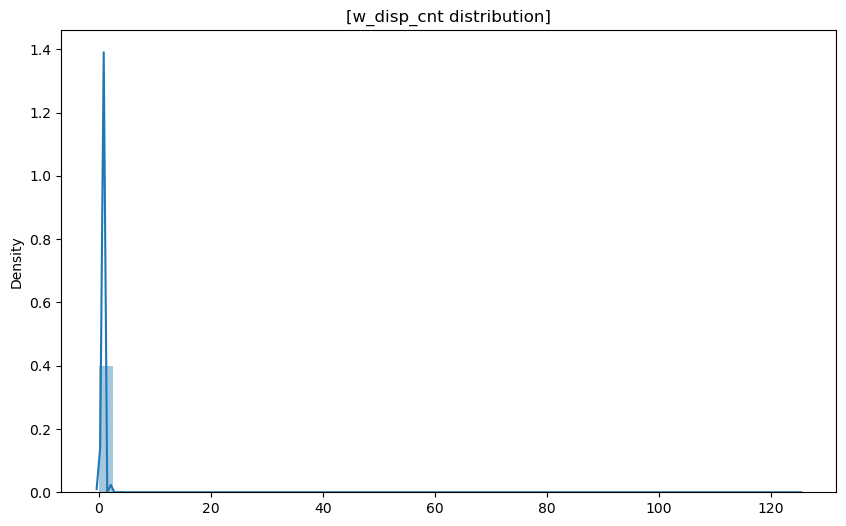

In [251]:
#그래프의 크기 지정
plt.figure(figsize=(10, 6))
sns.distplot(x=train_data['w_disp_cnt'])
plt.title("[w_disp_cnt distribution]")
plt.show()

findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not 

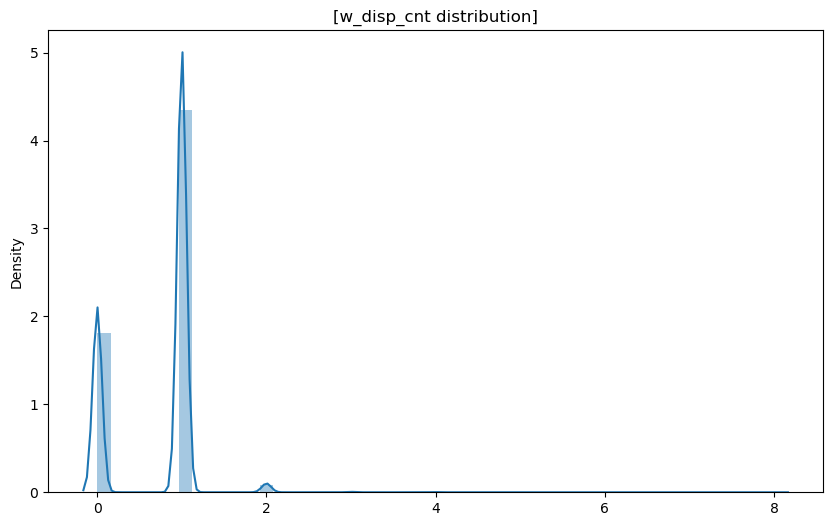

In [252]:
plt.figure(figsize=(10,6))
sns.distplot(x=train_data[train_data['w_disp_cnt']<10]['w_disp_cnt'])
plt.title("[w_disp_cnt distribution]")
plt.show()

In [253]:
#대체값은 1로 하기로 결정
train_data['w_disp_cnt'].fillna(train_data['w_disp_cnt'].median(), inplace=True)
#결측치 제거 결과 확인하기
train_data.isnull().sum().sum(), test_data.isnull().sum().sum()

(0, 0)

In [254]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    55000 non-null  object 
 1   status                55000 non-null  object 
 2   new_date              55000 non-null  int64  
 3   bidet_cnt             55000 non-null  int64  
 4   w_disp_cnt            55000 non-null  float64
 5   cust_cd               55000 non-null  int64  
 6   sex_cd                55000 non-null  object 
 7   w_disp_yn             55000 non-null  object 
 8   bidet_yn              55000 non-null  object 
 9   comb_prod_yn          55000 non-null  object 
 10  bidet_comb_yn         55000 non-null  object 
 11  w_disp_comb_yn        55000 non-null  object 
 12  bidet_trmn_eperd_cd   55000 non-null  object 
 13  w_disp_trmn_eperd_cd  55000 non-null  object 
 14  w_disp_trmn_why_cd    55000 non-null  object 
 15  bidet_trmn_why_cd  

In [255]:
#실제와 데이터 유형이 다른 칼럼 확인하기
train_data.loc[:5, ['new_date', 'cust_cd']]

,new_date,cust_cd
0,20170421,10001
1,20131203,10001
2,20170731,10001
3,20090930,10001
4,20151121,10001
5,20120711,10001


In [256]:
#수치형으로 되어있는 new_date를 datetime(날짜형)으로 변경
def GetDateTime(date):
    date = datetime.strptime(str(date), '%Y%m%d')
    return date

#map 함수로 new_date에 GetDateTime 함수를 적용하여 datetime으로 변경
train_data['new_date'] = train_data['new_date'].map(lambda x: GetDateTime(x))
test_data['new_date'] = test_data['new_date'].map(lambda x: GetDateTime(x))

#데이터형 확인하기
print('new_date: ',train_data['new_date'].dtype)


new_date:  datetime64[ns]


In [257]:
#cust_cd를 object로 변경
train_data['cust_cd']=train_data['cust_cd'].astype('O')
test_data['cust_cd']=test_data['cust_cd'].astype('O')
print('cust_cd: ',train_data['cust_cd'].dtype)

cust_cd:  object


In [258]:
train_data['new_date'].max(), test_data['new_date'].max()

(Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-30 00:00:00'))

In [259]:
(datetime(2020,8,31,0,0) - train_data['new_date']).head()

0   1228 days
1   2463 days
2   1127 days
3   3988 days
4   1745 days
Name: new_date, dtype: timedelta64[ns]

In [260]:
#파생 변수 추가하기. dt.days를 붙이면 int형으로 변경 가능
train_data['join_period'] = (datetime(2020, 8, 31, 0, 0) - train_data['new_date']).dt.days
test_data['join_period'] = (datetime(2020, 9, 30, 0, 0) - test_data['new_date']).dt.days
train_data['join_period'].head()

0    1228
1    2463
2    1127
3    3988
4    1745
Name: join_period, dtype: int64

In [261]:
#상품 해지경과기간코드 관련 파생변수 추가

In [262]:
teperd_cols = ['w_disp_trmn_eperd_cd', 'bidet_trmn_eperd_cd']
train_data.loc[:,teperd_cols]

,w_disp_trmn_eperd_cd,bidet_trmn_eperd_cd
0,_,_
1,_,_
2,_,_
3,_,_
4,_,_
...,...,...
54995,_,_
54996,_,R37
54997,_,_
54998,_,_


In [263]:
train_data['w_disp_trmn_eperd_cd'].value_counts()

_      51578
R37     1161
0        462
R01      120
R02       86
R06       85
R05       82
R04       78
R03       69
R09       67
R28       63
R18       60
R11       58
R15       55
R07       54
R12       53
R10       53
R25       51
R14       50
R17       48
R08       46
R26       45
R19       45
R16       43
R27       40
R21       39
R35       39
R24       38
R23       37
R13       37
R30       34
R29       32
R32       31
R20       31
R22       30
R31       30
R34       28
R36       26
R33       16
Name: w_disp_trmn_eperd_cd, dtype: int64

In [264]:
#Rxx 코드를 정수형(int)으로 변경하기 위한 함수 정의하기
def Rcdtoint(Rcd):
    if Rcd =='_': #해지 x
        return 38
    elif Rcd=='0': #해지 당월
        return 0
    else:
        return int(Rcd[1:3]) #해지 후 경과 기간 숫자만 남기기
#반복문 수행하면서 teperd_cols에 Rcdtoint() 함수 적용하기
for column in teperd_cols:
    new_column=column.replace('_trmn_eperd_cd', '_teperd')
    train_data[new_column] = train_data[column].apply(lambda x: Rcdtoint(x))
    test_data[new_column] = test_data[column].apply(lambda x: Rcdtoint(x))

train_data.iloc[:, -2:]

,w_disp_teperd,bidet_teperd
0,38,38
1,38,38
2,38,38
3,38,38
4,38,38
...,...,...
54995,38,38
54996,38,37
54997,38,38
54998,38,38


In [265]:
#_engt_rperd_cd 약정 잔여기간 코드 관련 파생변수 추가

In [266]:
erperd_cols=['w_disp_engt_rperd_cd', 'bidet_engt_rperd_cd']
train_data.loc[:,erperd_cols].head()

,w_disp_engt_rperd_cd,bidet_engt_rperd_cd
0,R09,R12
1,_,R06
2,0,_
3,P36,R11
4,R27,R22


In [267]:
#범주 분포 확인
train_data['bidet_engt_rperd_cd'].value_counts()

_      10996
R12     3864
R07     2108
R06     1940
R11     1888
       ...  
P33       29
P35       20
P36       20
P34       19
R34        1
Name: bidet_engt_rperd_cd, Length: 71, dtype: int64

In [268]:
#전체 범주가 표시되지 않아서 값의 개수 없이 범주만 확인
train_data['bidet_engt_rperd_cd'].value_counts().index

Index(['_', 'R12', 'R07', 'R06', 'R11', 'R10', 'R09', 'R13', 'R24', 'R08',
       'R23', 'R14', 'R22', 'R05', 'R15', 'R04', 'R21', 'R02', 'R01', 'R30',
       'R20', 'R18', 'R16', 'R03', 'R19', 'R29', 'R17', '0', 'R28', 'R25',
       'P37', 'R26', 'R27', 'P01', '|', 'P02', 'P04', 'P06', 'P03', 'P07',
       'P05', 'P08', 'P09', 'P11', 'P12', 'P10', 'P15', 'P14', 'P13', 'P16',
       'P18', 'P19', 'P22', 'P20', 'P21', 'P17', 'P24', 'P23', 'P26', 'P25',
       'P28', 'P31', 'P32', 'P27', 'P30', 'P29', 'P33', 'P35', 'P36', 'P34',
       'R34'],
      dtype='object')

In [269]:
#RXX, PXX를 정수형으로 변경하기 위한 함수 정의
def RPcdtoint(RPcd):
    if RPcd=='_': #무약정
        return int(38)
    elif RPcd == '0': #약정 만료월
        return int(0)
    elif RPcd[0]=='P': #PXX, 약정 만료 후 경과기간임
        return int(RPcd[1:3])
    elif RPcd =='|':
        return int(0)
    else: #RXX, 잔여 약정 기간 나타냄
        return -int(RPcd[1:3])

#반복문을 수행하면서 erperd_cols에 RPcdtoint()함수 작용하기
for column in erperd_cols:
    new_column=column.replace('_engt_rperd_cd', '_erperd')
    train_data[new_column]=''#새로운 칼럼 추가
    test_data[new_column]=''#새로운 칼럼 추가
    train_data[new_column]=train_data[column].map(lambda x:RPcdtoint(x))
    test_data[new_column]=test_data[column].map(lambda x:RPcdtoint(x))

#대상 칼럼 확인하기
train_data.iloc[:, -2:].head()

,w_disp_erperd,bidet_erperd
0,-9,-12
1,38,-6
2,0,38
3,36,-11
4,-27,-22


In [270]:
#불필요한 칼럼 삭제하기

In [271]:
#빈 리스트 생성하기
del_cols=[]

In [272]:
#id같은 유일값은 과대적합을 일으킨다.
del_cols.append('id')

In [273]:
#수치형 칼럼 담을 리스트
numbers=['int64', 'float64']
num_cols = train_data.select_dtypes(numbers).columns
num_cols

Index(['bidet_cnt', 'w_disp_cnt', '3m_avg_bill_amt', '3m_bidet_avg_amt',
       '3m_w_disp_avg_amt', 'voc_cnt_AS', 'voc_cnt_가입', 'voc_cnt_개통',
       'voc_cnt_변경/조회', 'voc_cnt_업무협조', 'voc_cnt_이용', 'voc_cnt_정보보호/언론보도',
       'voc_cnt_채널', 'voc_cnt_청구 수/미납', 'voc_cnt_품질', 'voc_cnt_해지',
       'voc_cnt_혜택', 'day_cnt_AS', 'day_cnt_가입', 'day_cnt_개통', 'day_cnt_변경/조회',
       'day_cnt_업무협조', 'day_cnt_이용', 'day_cnt_정보보호/언론보도', 'day_cnt_채널',
       'day_cnt_청구 수/미납', 'day_cnt_품질', 'day_cnt_해지', 'day_cnt_혜택',
       'join_period', 'w_disp_teperd', 'bidet_teperd', 'w_disp_erperd',
       'bidet_erperd'],
      dtype='object')

In [274]:
#범주형 칼럼 담을 리스트
obj_cols = train_data.select_dtypes('O').columns
obj_cols

Index(['id', 'status', 'cust_cd', 'sex_cd', 'w_disp_yn', 'bidet_yn',
       'comb_prod_yn', 'bidet_comb_yn', 'w_disp_comb_yn',
       'bidet_trmn_eperd_cd', 'w_disp_trmn_eperd_cd', 'w_disp_trmn_why_cd',
       'bidet_trmn_why_cd', 'npay_yn', 'w_disp_engt_rperd_cd',
       'bidet_engt_rperd_cd'],
      dtype='object')

In [275]:
train_data.loc[:, num_cols].describe()

,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_변경/조회,voc_cnt_업무협조,...,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
count,55000.000000,55000.000000,5.500000e+04,5.500000e+04,5.500000e+04,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,...,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000
mean,2.596782,0.737255,2.915999e+05,3.441105e+04,4.162946e+04,0.043600,0.129927,0.019491,0.214673,0.332455,...,0.075455,0.219764,0.110327,0.272909,0.035927,1858.126418,36.910036,36.868073,14.556655,-0.750909
std,66.479010,1.137088,8.496803e+05,3.833091e+04,3.965128e+05,0.256391,0.366102,0.166522,0.552657,0.885980,...,0.316198,0.464854,0.351533,0.518703,0.204719,1616.054444,5.627786,5.708939,26.564439,22.156265
min,0.000000,0.000000,-1.136300e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-37.000000,-34.000000
25%,1.000000,0.000000,1.102485e+05,1.131050e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,748.000000,38.000000,38.000000,-9.000000,-15.000000
50%,1.000000,1.000000,1.994620e+05,3.107550e+04,3.266000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1357.000000,38.000000,38.000000,33.000000,-8.000000
75%,2.000000,1.000000,3.363403e+05,4.804125e+04,4.791800e+04,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2517.000000,38.000000,38.000000,38.000000,7.000000
max,5077.000000,125.000000,1.806220e+08,3.092769e+06,6.078027e+07,7.000000,6.000000,5.000000,59.000000,102.000000,...,9.000000,7.000000,7.000000,6.000000,6.000000,8396.000000,38.000000,38.000000,38.000000,38.000000


In [276]:
#수치형 칼럼에서 0의 비중이 90% 넘는 칼럼 찾기
for column in num_cols:
    if(((train_data[column]==0).sum()/55000) > 0.9):
        print(column+':'+(str)((train_data[column]==0).sum()/55000))
        del_cols.append(column)
    

voc_cnt_AS:0.9651272727272727
voc_cnt_개통:0.9838181818181818
voc_cnt_정보보호/언론보도:0.9937090909090909
voc_cnt_채널:0.9343090909090909
voc_cnt_품질:0.9000363636363636
voc_cnt_혜택:0.9671818181818181
day_cnt_AS:0.9651272727272727
day_cnt_개통:0.9838181818181818
day_cnt_정보보호/언론보도:0.9937090909090909
day_cnt_채널:0.9343090909090909
day_cnt_품질:0.9000363636363636
day_cnt_혜택:0.9671818181818181


In [277]:
#범주형 칼럼에서 가장 많은 범주의 비중이 90% 넘는 칼럼 찾기
for column in obj_cols:
    if((train_data[column].value_counts().iloc[0]/55000) >0.9):
        print(column+':'+(str)(train_data[column].value_counts().iloc[0]/55000))
        del_cols.append(column)

cust_cd:0.9760181818181818
bidet_trmn_eperd_cd:0.9267454545454545
w_disp_trmn_eperd_cd:0.9377818181818182
w_disp_trmn_why_cd:0.9420363636363637
bidet_trmn_why_cd:0.9294363636363636


In [278]:
#파생변수 만들어 대체한 칼럼 처리하기
#del_cols에 삭제 대상 추가하기
del_cols=del_cols+['new_date', 'w_disp_engt_rperd_cd', 'bidet_engt_rperd_cd']
print(del_cols)

['id', 'voc_cnt_AS', 'voc_cnt_개통', 'voc_cnt_정보보호/언론보도', 'voc_cnt_채널', 'voc_cnt_품질', 'voc_cnt_혜택', 'day_cnt_AS', 'day_cnt_개통', 'day_cnt_정보보호/언론보도', 'day_cnt_채널', 'day_cnt_품질', 'day_cnt_혜택', 'cust_cd', 'bidet_trmn_eperd_cd', 'w_disp_trmn_eperd_cd', 'w_disp_trmn_why_cd', 'bidet_trmn_why_cd', 'new_date', 'w_disp_engt_rperd_cd', 'bidet_engt_rperd_cd']


In [279]:
#리스트에 저장한 삭제 대상 칼럼을 일괄 삭제하기

In [280]:
train_data.drop(del_cols, axis=1, inplace=True)
test_data.drop(del_cols, axis=1, inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             55000 non-null  object 
 1   bidet_cnt          55000 non-null  int64  
 2   w_disp_cnt         55000 non-null  float64
 3   sex_cd             55000 non-null  object 
 4   w_disp_yn          55000 non-null  object 
 5   bidet_yn           55000 non-null  object 
 6   comb_prod_yn       55000 non-null  object 
 7   bidet_comb_yn      55000 non-null  object 
 8   w_disp_comb_yn     55000 non-null  object 
 9   npay_yn            55000 non-null  object 
 10  3m_avg_bill_amt    55000 non-null  float64
 11  3m_bidet_avg_amt   55000 non-null  int64  
 12  3m_w_disp_avg_amt  55000 non-null  int64  
 13  voc_cnt_가입         55000 non-null  int64  
 14  voc_cnt_변경/조회      55000 non-null  int64  
 15  voc_cnt_업무협조       55000 non-null  int64  
 16  voc_cnt_이용         550

In [281]:
#status 값 분포 확인하기
train_data['status'].value_counts()

Y    31806
N    23194
Name: status, dtype: int64

<Axes: >

findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not 

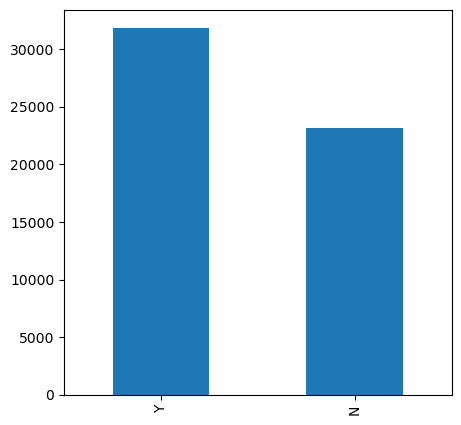

In [282]:
#status 칼럼을 막대 그래프로 그리기
train_data['status'].value_counts().plot(kind='bar')

findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not 

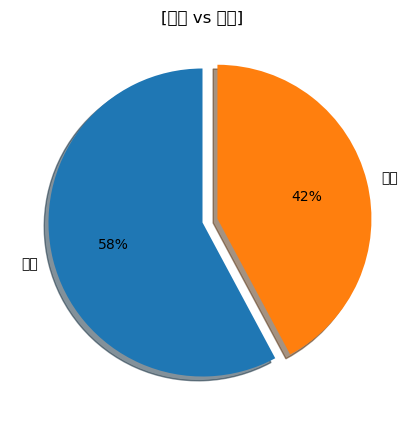

In [283]:
#status 칼럼을 파이 그래프로 그리기
data = train_data['status'].value_counts()
labels=['유지', '해지']
plt.pie(data, labels = labels, autopct='%.0f%%', shadow=True, explode=(0,0.1), startangle=90,)
plt.title("[유지 vs 해지]")
plt.show()

대상 칼럼 수: 22


100%|██████████| 22/22 [00:00<00:00, 103.54it/s]
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not foun

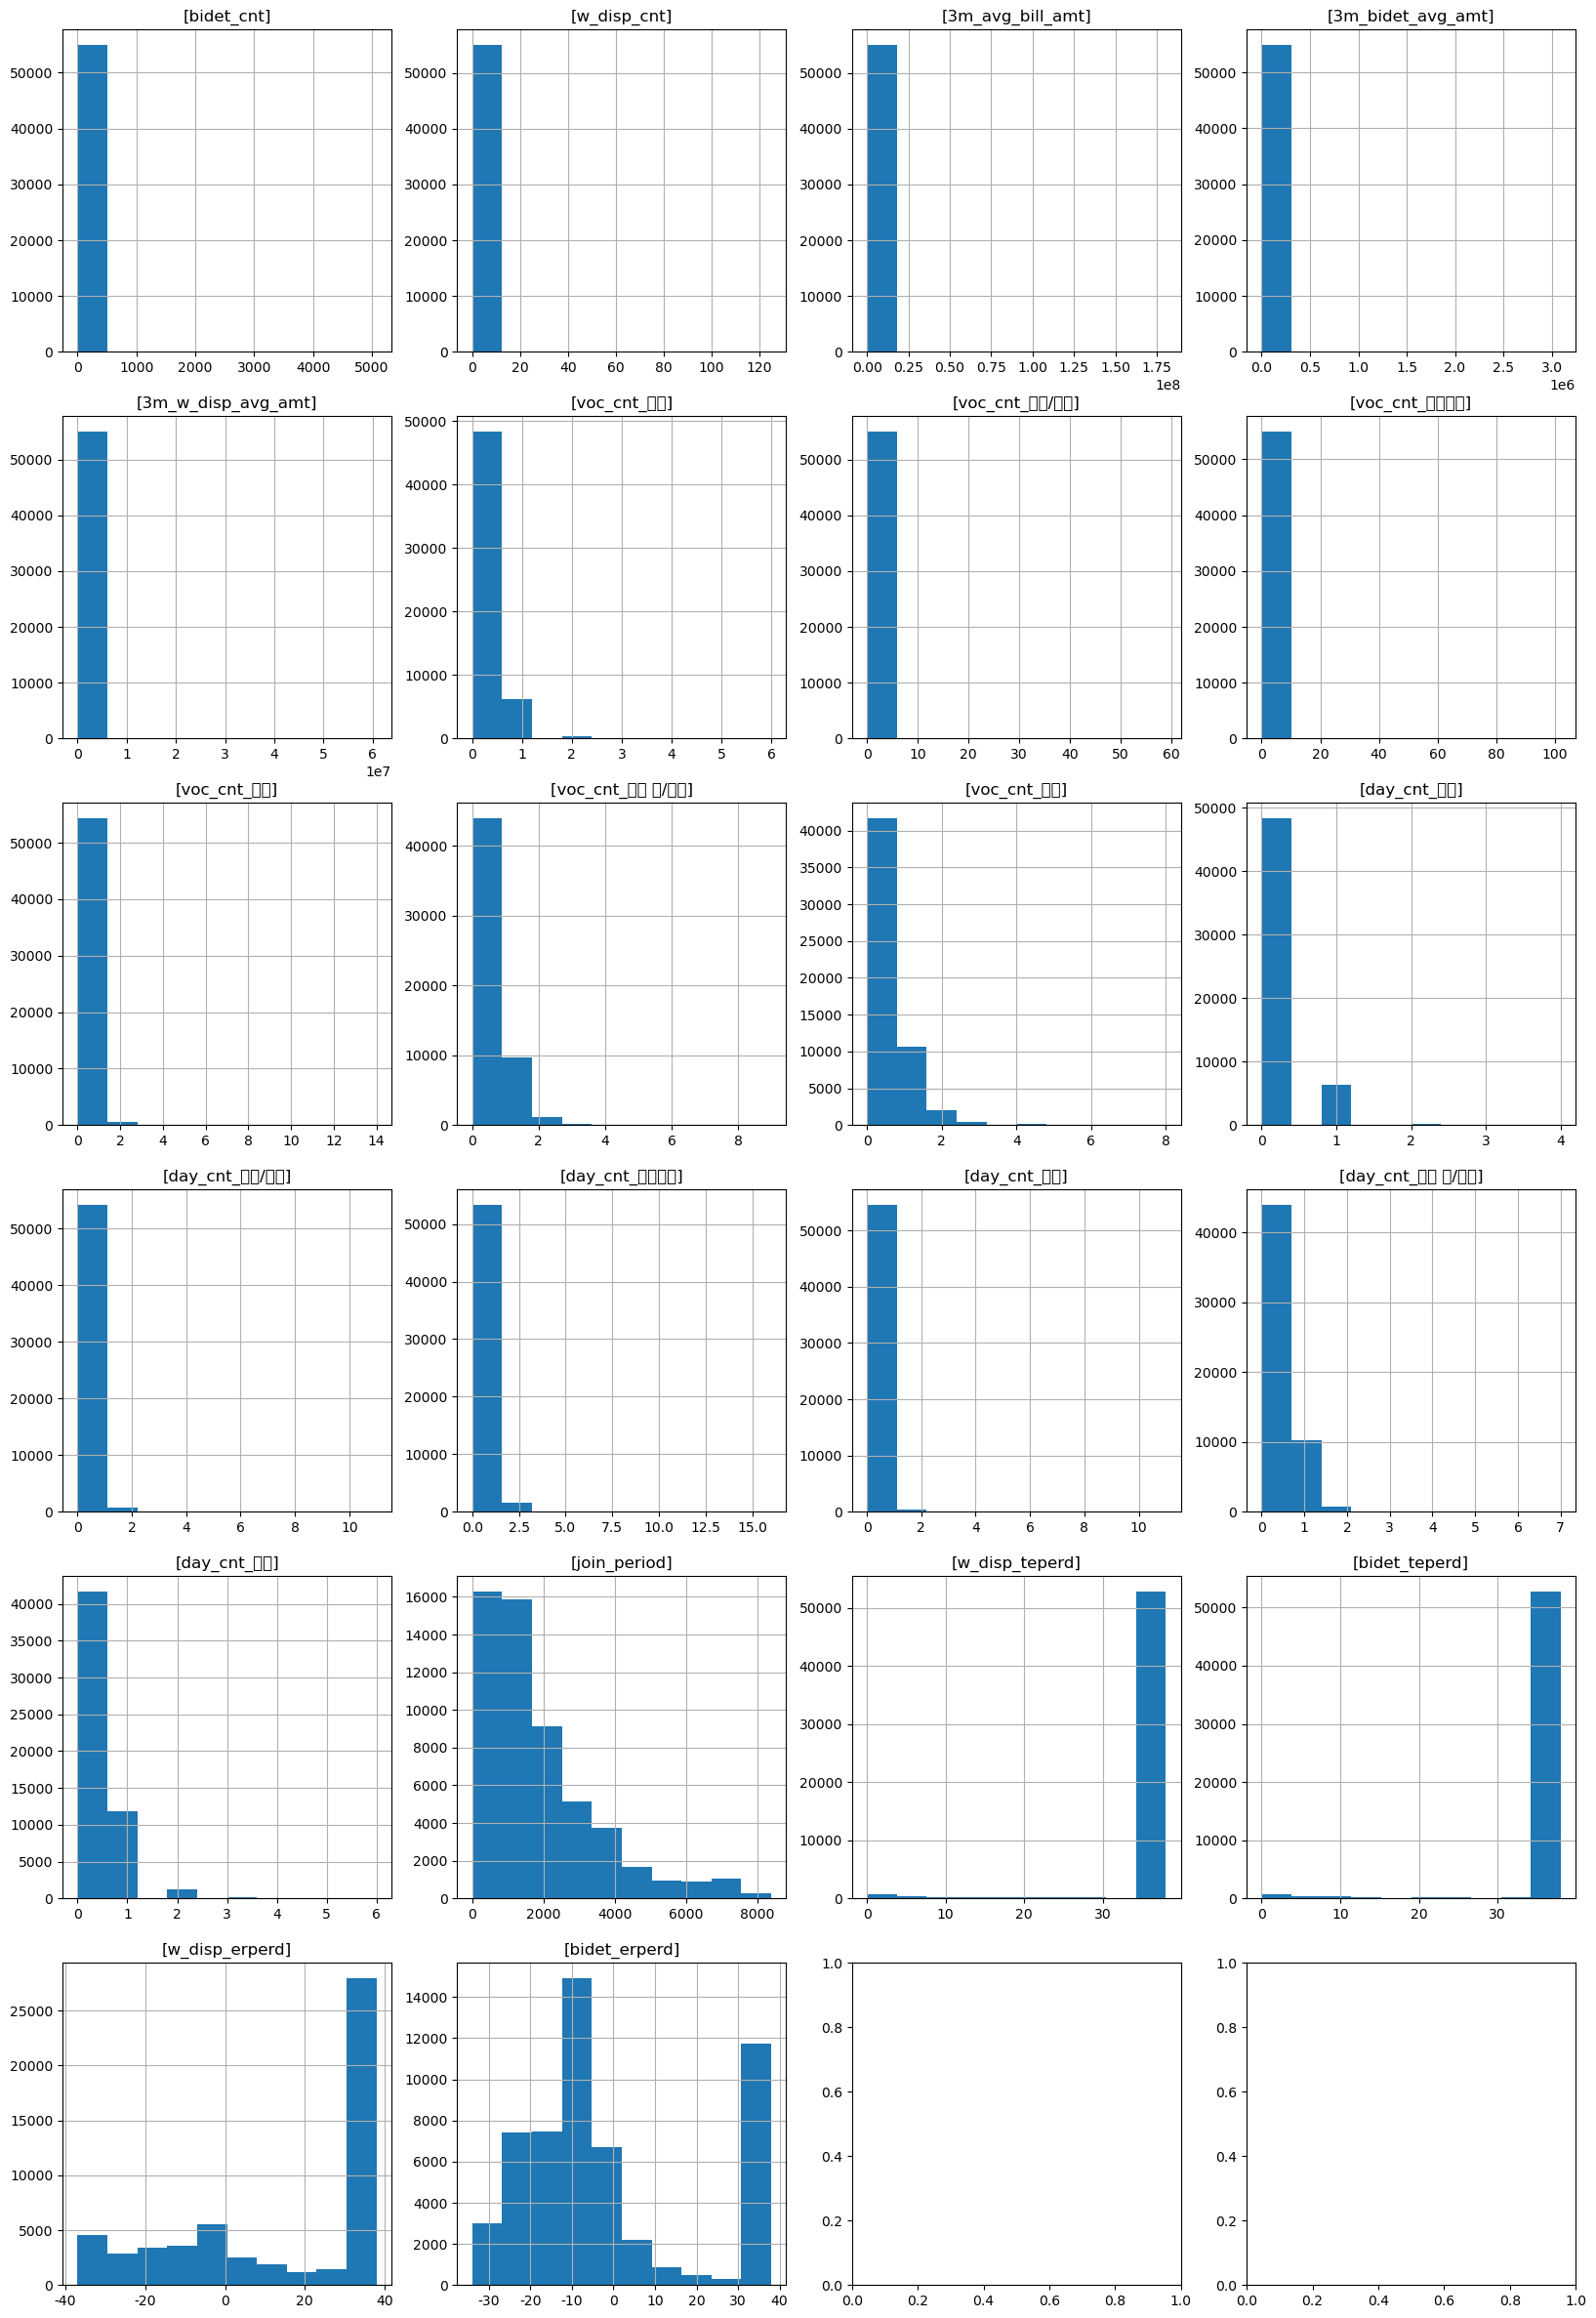

In [284]:
#전처리 후에 변경이 있으므로 수치형 칼럼을 모은 num_cols 리스트를 다시 생성하기
numbers=['int64', 'float64']
num_cols = train_data.select_dtypes(numbers).columns

#모든 수치형 칼럼에 대해 히스토그램을 그리는 함수
def make_histplot(df, num_cols, label):
    col_cnt=4
    graph_size=5
    num=len(num_cols)
    print("대상 칼럼 수:", num)

    #그려야 할 전체 그래프 크기 정하기
    plt.rcParams['figure.figsize']=(col_cnt*graph_size, math.ceil(num/col_cnt)*graph_size)
    #그려야 할 각각의 그래프 위치 정하기
    fig, ax = plt.subplots(ncols=col_cnt, nrows=math.ceil(num/col_cnt))
    i=0
    for column in tqdm(num_cols):
        df[column].hist(ax=ax[int(i/col_cnt)][i%col_cnt])
        ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']')
        i=i+1
    plt.show()
    plt.rcParams['figure.figsize']=(7,7)

make_histplot(train_data, num_cols, 'status')

In [285]:
train_data.describe()

,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_가입,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_청구 수/미납,...,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
count,55000.000000,55000.000000,5.500000e+04,5.500000e+04,5.500000e+04,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,...,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000
mean,2.596782,0.737255,2.915999e+05,3.441105e+04,4.162946e+04,0.129927,0.214673,0.332455,0.124055,0.232273,...,0.201436,0.284218,0.117691,0.219764,0.272909,1858.126418,36.910036,36.868073,14.556655,-0.750909
std,66.479010,1.137088,8.496803e+05,3.833091e+04,3.965128e+05,0.366102,0.552657,0.885980,0.398879,0.510258,...,0.447934,0.580211,0.362700,0.464854,0.518703,1616.054444,5.627786,5.708939,26.564439,22.156265
min,0.000000,0.000000,-1.136300e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-37.000000,-34.000000
25%,1.000000,0.000000,1.102485e+05,1.131050e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,748.000000,38.000000,38.000000,-9.000000,-15.000000
50%,1.000000,1.000000,1.994620e+05,3.107550e+04,3.266000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1357.000000,38.000000,38.000000,33.000000,-8.000000
75%,2.000000,1.000000,3.363403e+05,4.804125e+04,4.791800e+04,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2517.000000,38.000000,38.000000,38.000000,7.000000
max,5077.000000,125.000000,1.806220e+08,3.092769e+06,6.078027e+07,6.000000,59.000000,102.000000,14.000000,9.000000,...,11.000000,16.000000,11.000000,7.000000,6.000000,8396.000000,38.000000,38.000000,38.000000,38.000000


In [286]:
#각 칼럼별 max값 확인하기
train_data.describe().loc['max']

bidet_cnt            5.077000e+03
w_disp_cnt           1.250000e+02
3m_avg_bill_amt      1.806220e+08
3m_bidet_avg_amt     3.092769e+06
3m_w_disp_avg_amt    6.078027e+07
voc_cnt_가입           6.000000e+00
voc_cnt_변경/조회        5.900000e+01
voc_cnt_업무협조         1.020000e+02
voc_cnt_이용           1.400000e+01
voc_cnt_청구 수/미납      9.000000e+00
voc_cnt_해지           8.000000e+00
day_cnt_가입           4.000000e+00
day_cnt_변경/조회        1.100000e+01
day_cnt_업무협조         1.600000e+01
day_cnt_이용           1.100000e+01
day_cnt_청구 수/미납      7.000000e+00
day_cnt_해지           6.000000e+00
join_period          8.396000e+03
w_disp_teperd        3.800000e+01
bidet_teperd         3.800000e+01
w_disp_erperd        3.800000e+01
bidet_erperd         3.800000e+01
Name: max, dtype: float64

In [287]:
#max값이 20 초과인 칼럼을 리스트로 만들기
outlier_cols=train_data.describe().loc['max'][train_data.describe().loc['max']>20].index.tolist()
outlier_cols

['bidet_cnt',
 'w_disp_cnt',
 '3m_avg_bill_amt',
 '3m_bidet_avg_amt',
 '3m_w_disp_avg_amt',
 'voc_cnt_변경/조회',
 'voc_cnt_업무협조',
 'join_period',
 'w_disp_teperd',
 'bidet_teperd',
 'w_disp_erperd',
 'bidet_erperd']

In [288]:
#이상치 기준이 되는 upperfence와 lowerfence 지점의 위치 값을 계산하고 반환하기
def outliers_iqr(df, column, uorl, upper=75, lower=25, factor=1.5):
    q1, q3 = np.percentile(df[column], [lower, upper])
    iqr = q3-q1
    if uorl =='l':
        return (q1-(iqr*factor))
    elif uorl =='u':
        return (q3+(iqr*factor))
#이상치를 upperfence로 대체하는 함수, lower는 고려하지 않음
def replace_outlier(df, cols, upper=75, lower=25, factor=1.5):
    for column in cols:
        upperfence=outliers_iqr(df, column, 'u', upper,lower,factor)
        df[column]=df[column].apply(lambda x: x if x <= upperfence else upperfence)

#시각화를 위한 데이터는 따로 복제하여 이상치를 제거하여 사용
train_data_del_outlier = train_data.copy()
replace_outlier(train_data_del_outlier,outlier_cols, factor=1.5)

대상 칼럼 수: 22


100%|██████████| 22/22 [00:01<00:00, 19.10it/s] 
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not foun

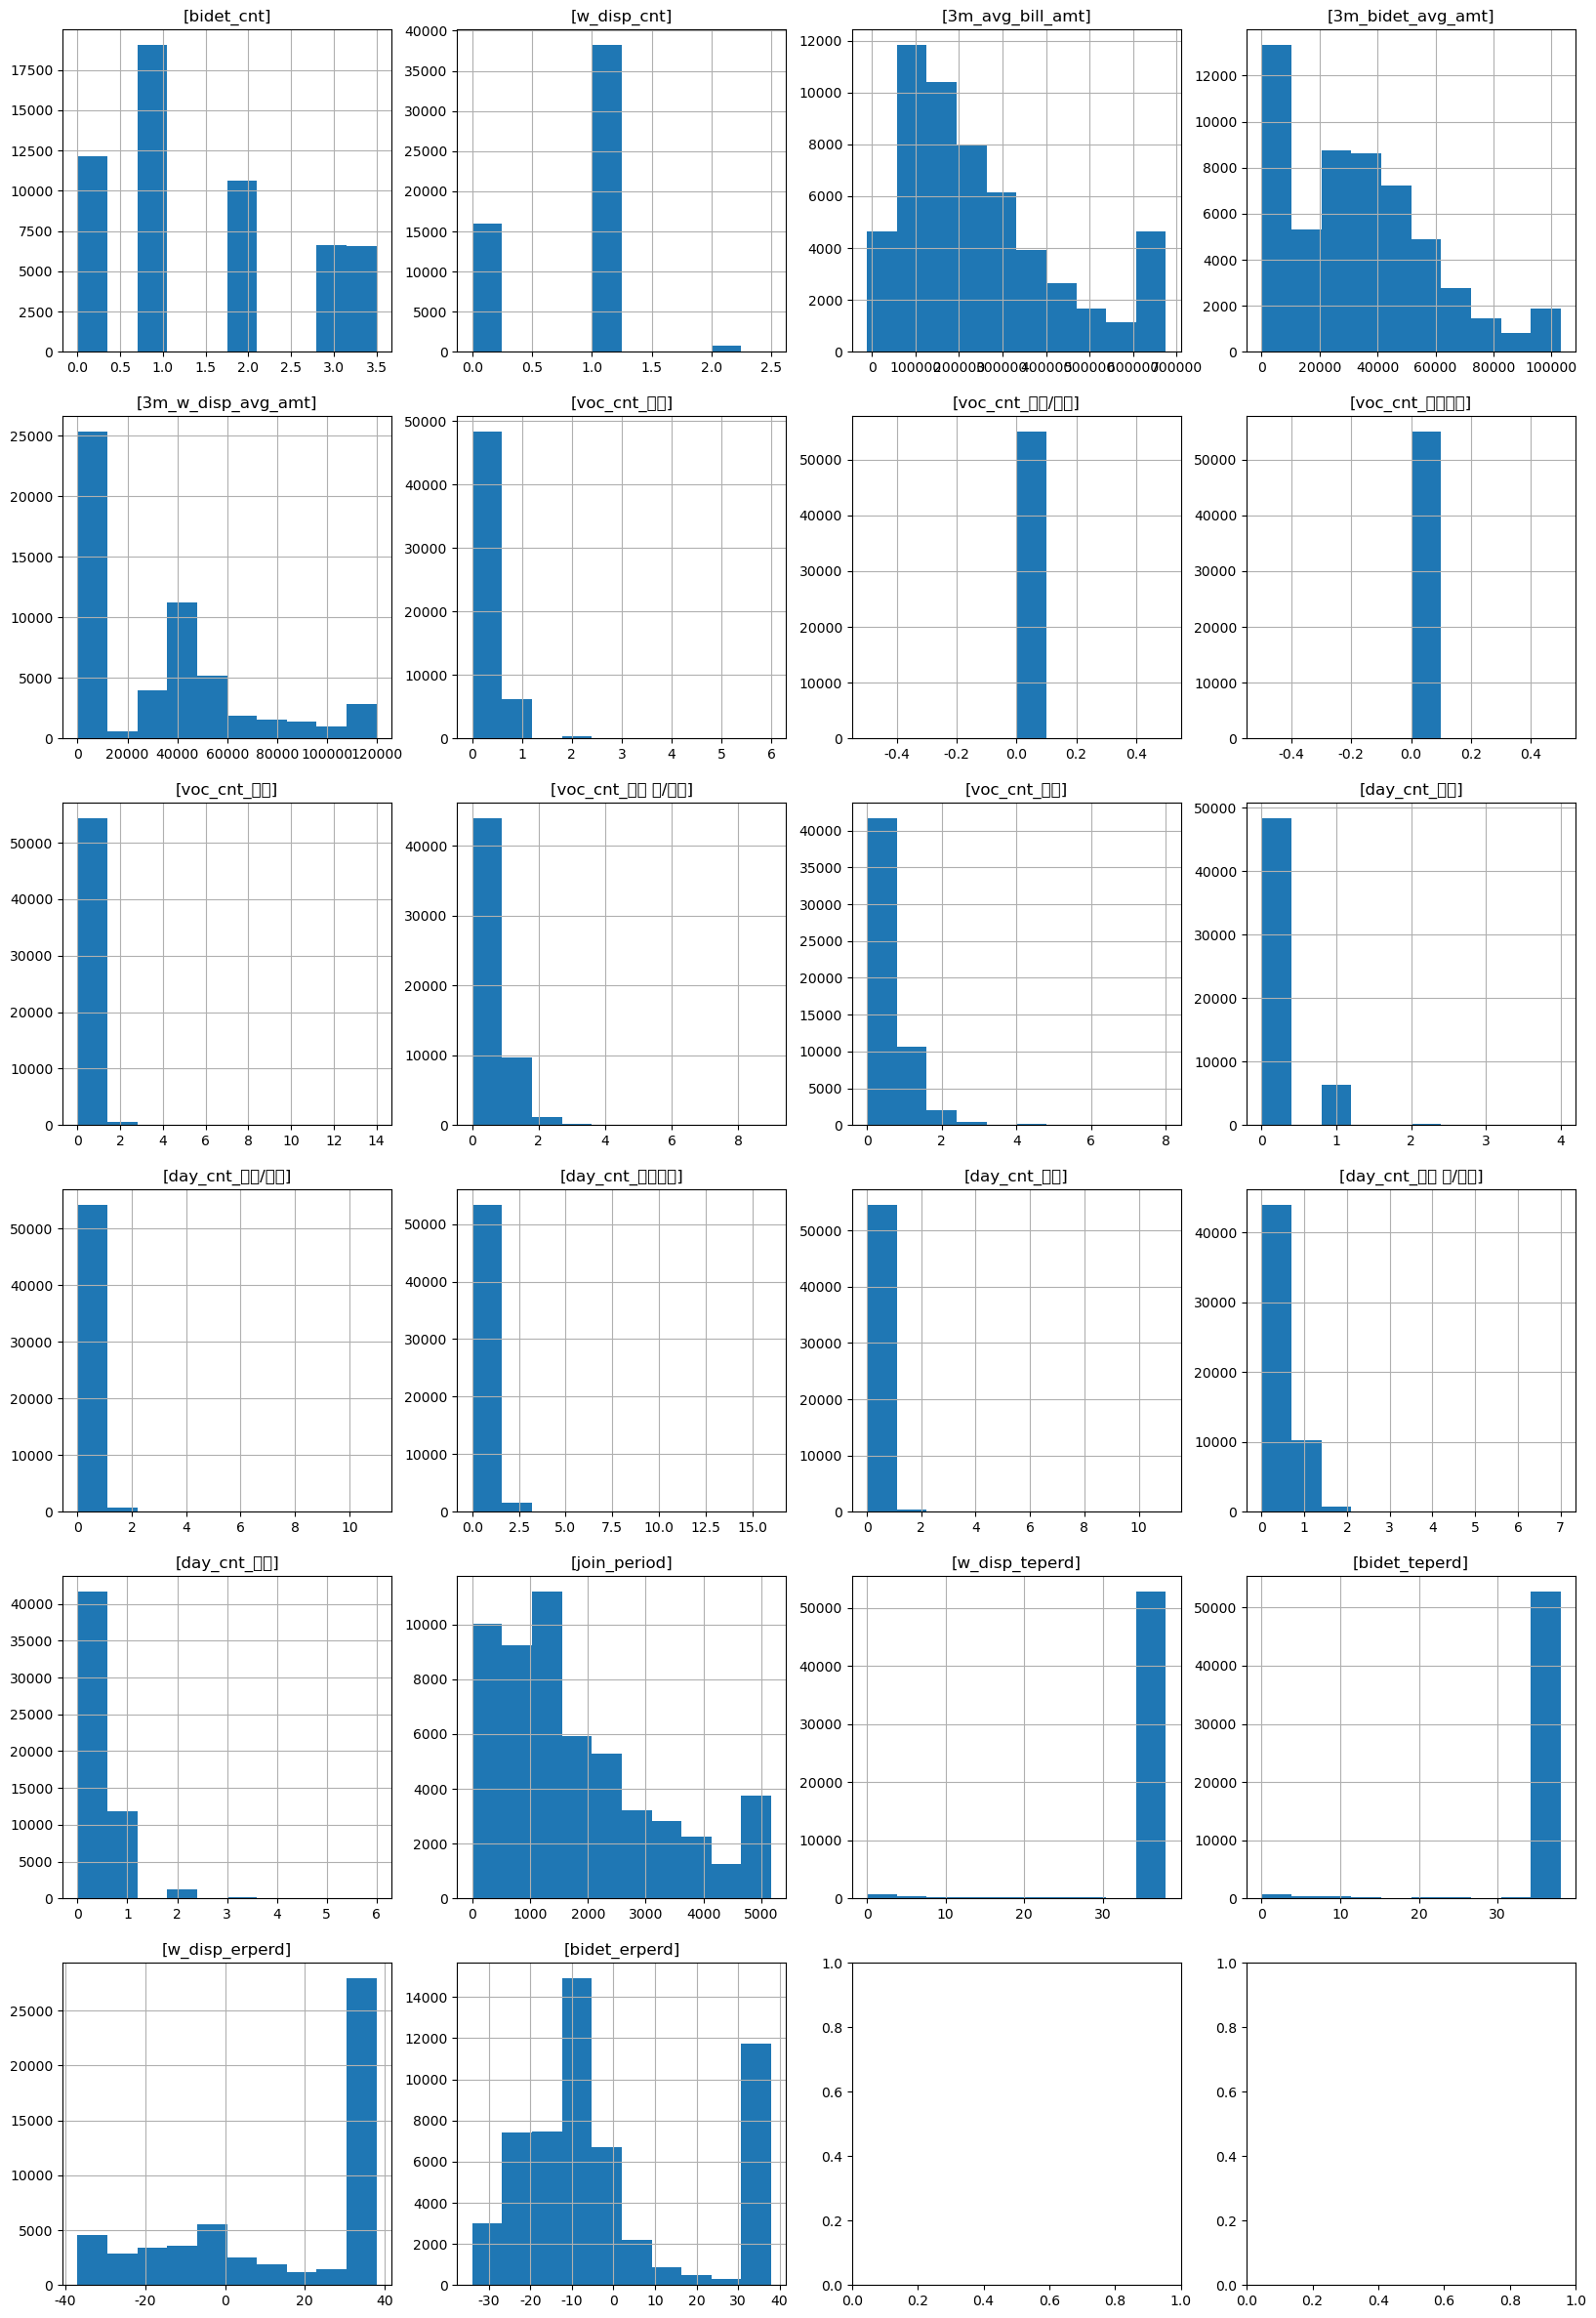

In [289]:
make_histplot(train_data_del_outlier, num_cols, 'status')

대상 칼럼수: 22


100%|██████████| 22/22 [00:07<00:00,  2.83it/s]
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found

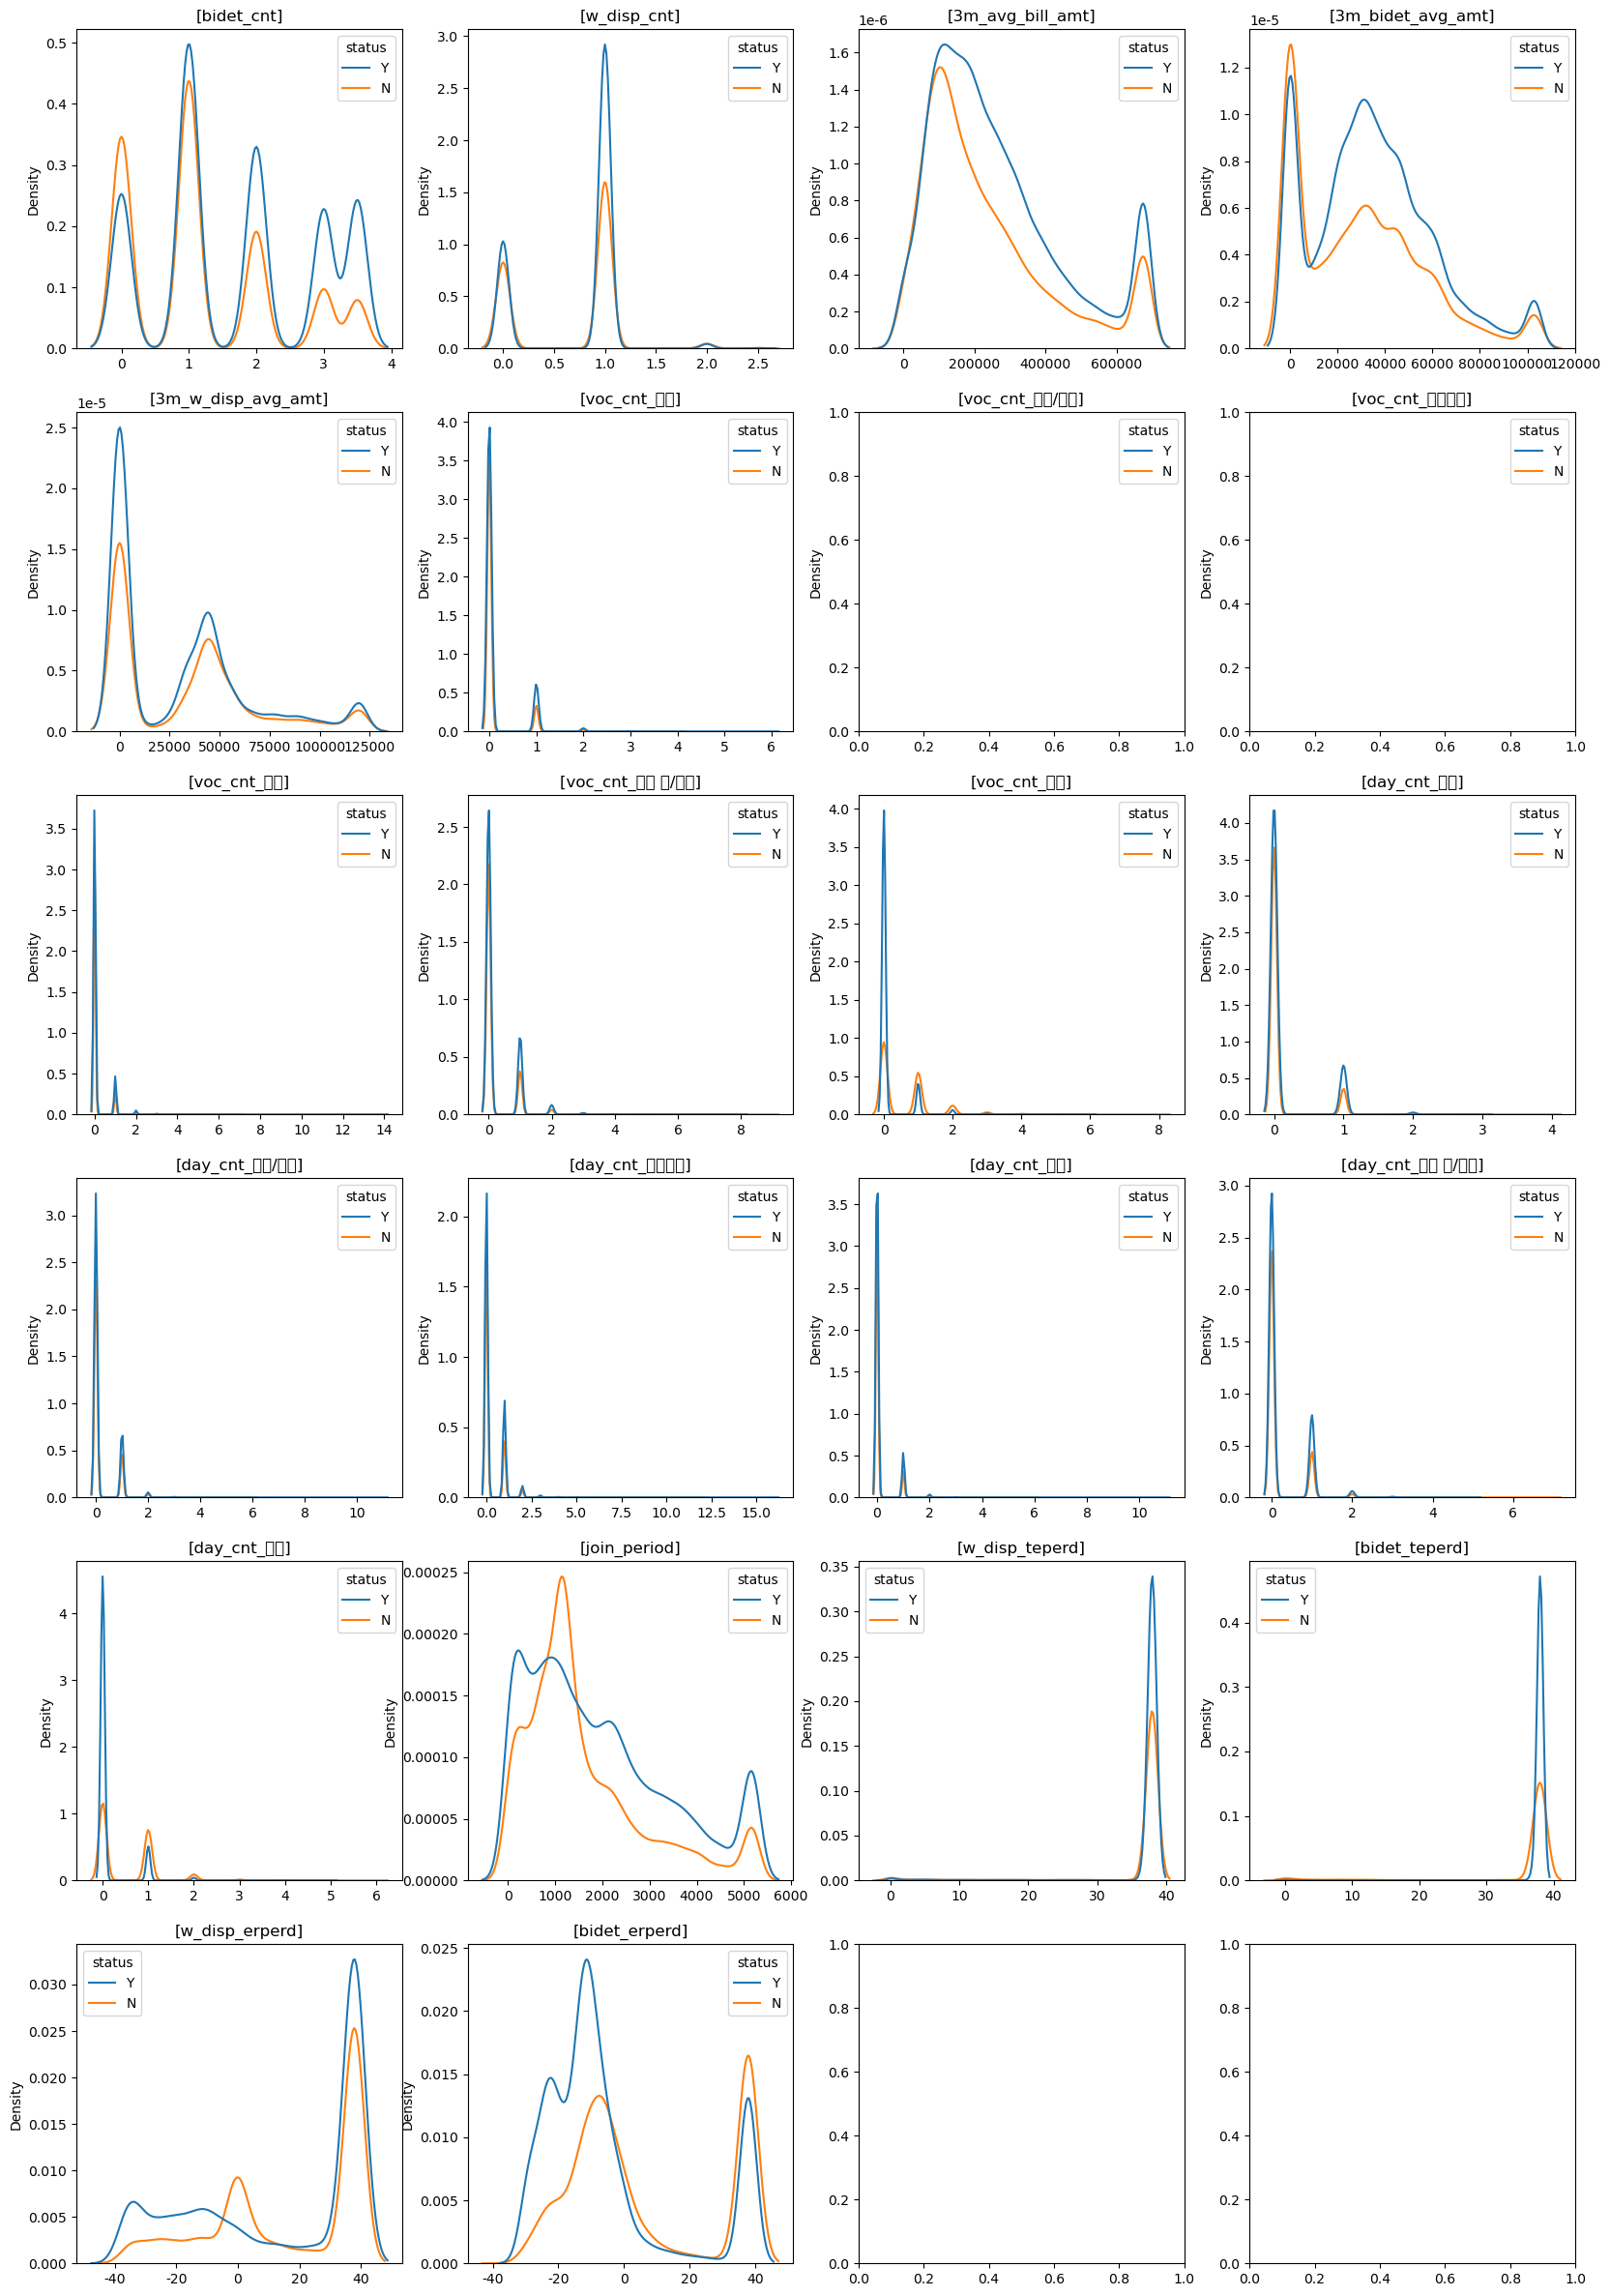

In [290]:
#수치형 칼럼에 대해서 커널밀도추정 그래프(kdeplot)를 그리는 함수
def make_kdeplot(df,num_cols,label):
    num=len(num_cols)
    col_cnt=4
    graph_size=5
    print("대상 칼럼수:", num)

    #그려야 할 전체 그래프의 크기 정하기
    plt.rcParams['figure.figsize']=(col_cnt*graph_size,math.ceil(num/col_cnt)*graph_size)
    #그려야 할 각각의 그래프 위치 정하기
    fig, ax = plt.subplots(ncols=col_cnt, nrows=math.ceil(num/col_cnt))
    i=0
    for column in tqdm(num_cols):
        sns.kdeplot(data=df, x=column, hue=label, ax=ax[int(i/col_cnt)][i%col_cnt])
        ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']')
        ax[int(i/col_cnt)][i%col_cnt].set_xlabel('')
        i=i+1
        
    plt.show()
    plt.rcParams['figure.figsize']=(7,7)

make_kdeplot(train_data_del_outlier, num_cols, 'status')

대상 칼럼 수: 22


100%|██████████| 22/22 [00:11<00:00,  1.96it/s]
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found

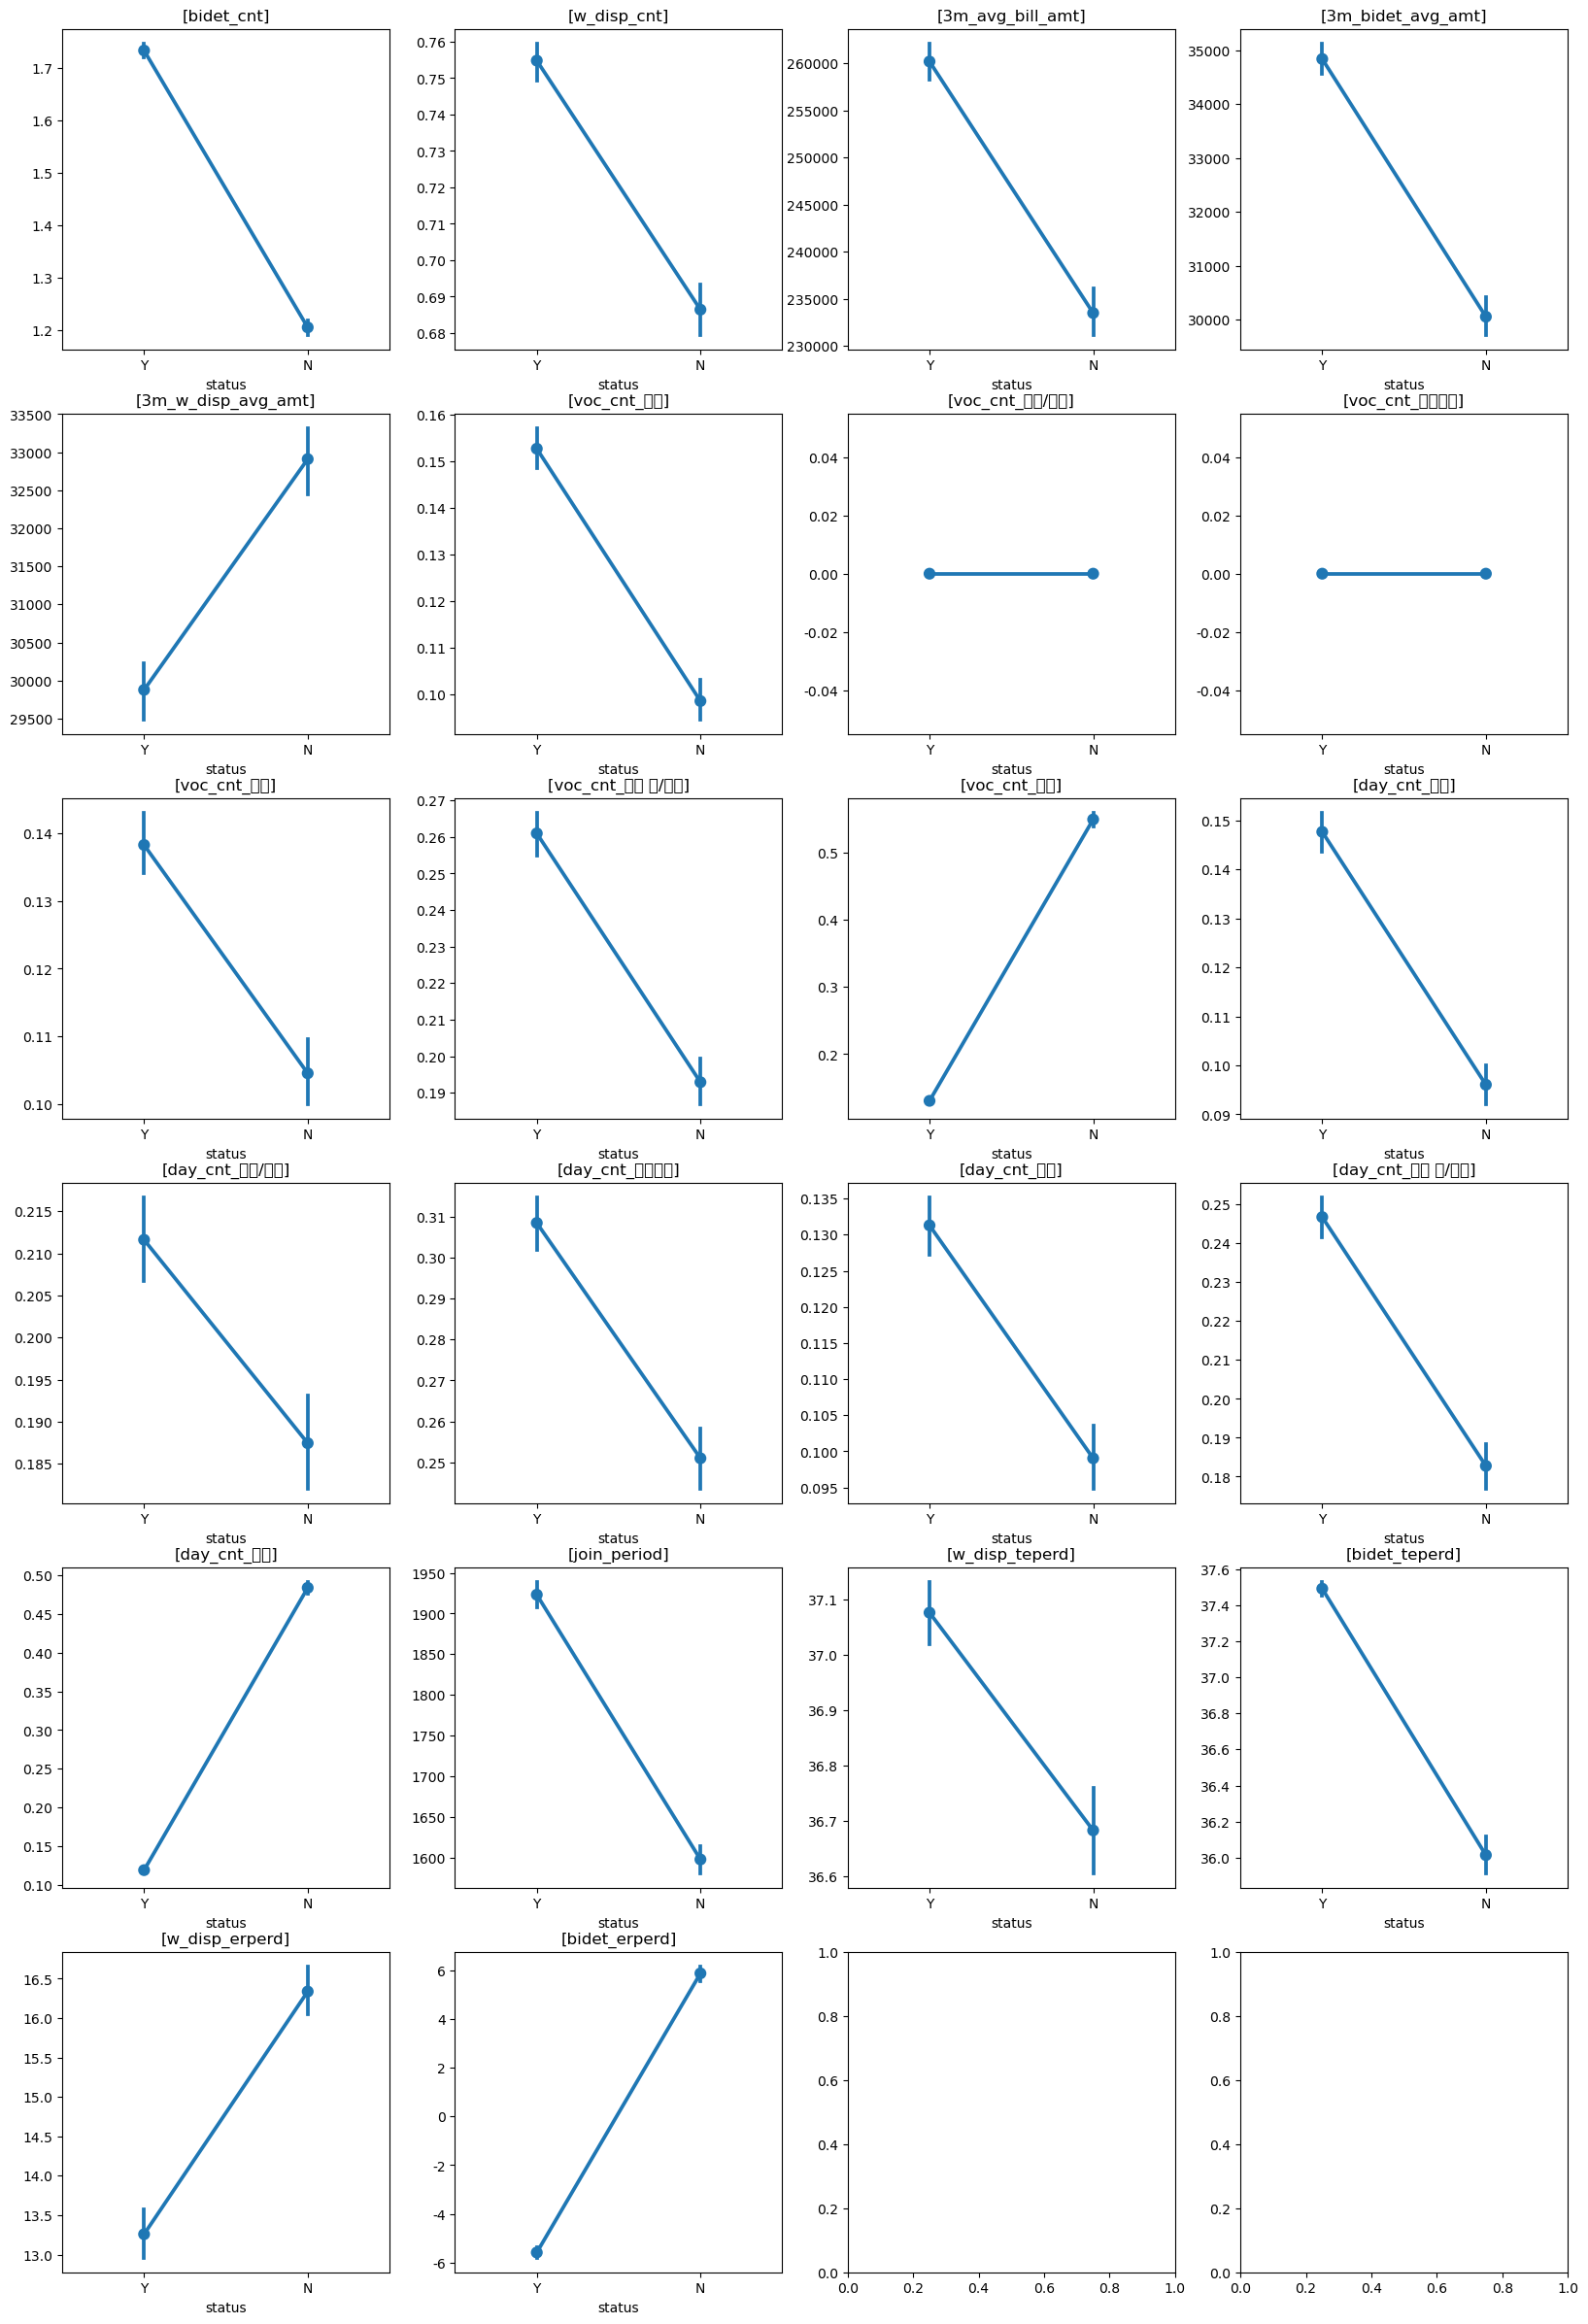

In [291]:
#수치형 칼럼에 대해 포인트 그래프를 그리는 함수 생성하기
def make_pointplot(df,num_cols, label):
    num=len(num_cols)
    col_cnt=4
    graph_size=5
    print("대상 칼럼 수:", num)

    #그려야 할 전체 그래프 크기 정하기
    plt.rcParams['figure.figsize']=(col_cnt*graph_size,math.ceil(num/col_cnt)*graph_size)
    #그려야 할 각각의 그래프 위치 정하기
    fig, ax = plt.subplots(ncols=col_cnt, nrows=math.ceil(num/col_cnt))
    i=0
    for column in tqdm(num_cols):
        sns.pointplot(data=df, y=column, x=label, ax=ax[int(i/col_cnt)][i%col_cnt])
        ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']')
        ax[int(i/col_cnt)][i%col_cnt].set_ylabel('')
        i=i+1
    plt.show()
    plt.rcParams['figure.figsize']=(7,7)
make_pointplot(train_data_del_outlier, num_cols, 'status')

In [292]:
#범주형 데이터 분석하기

In [293]:
obj_cols = train_data.select_dtypes('O').columns
obj_cols

Index(['status', 'sex_cd', 'w_disp_yn', 'bidet_yn', 'comb_prod_yn',
       'bidet_comb_yn', 'w_disp_comb_yn', 'npay_yn'],
      dtype='object')

대상 칼럼수: 8


findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not 

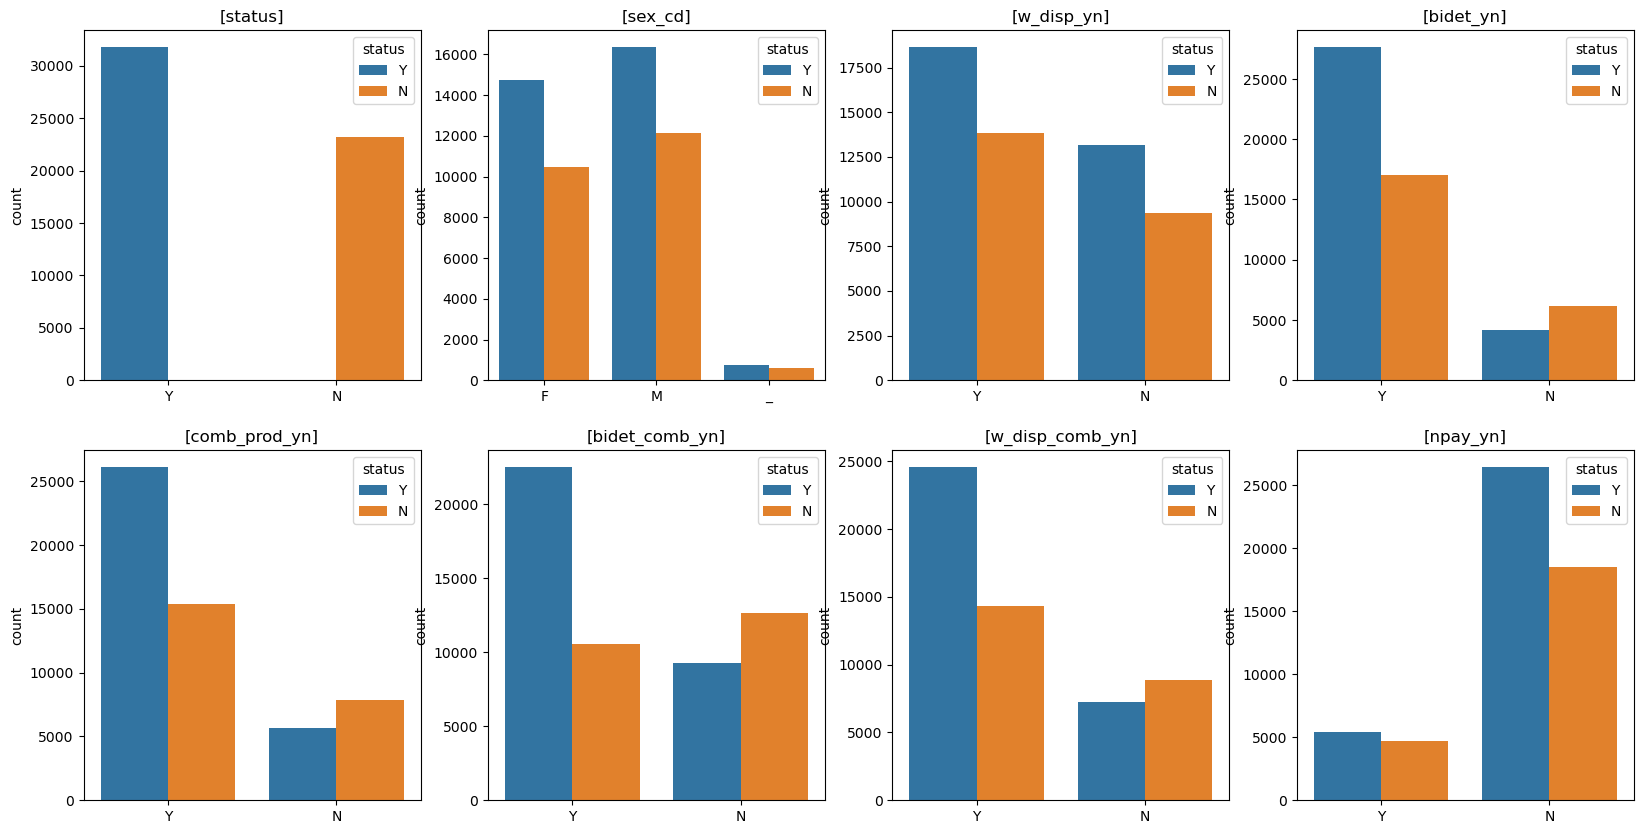

In [294]:
#범주형 칼럼에 대해 빈도그래프를 그리는 함수 생성하기
def make_countplot(df, obj_cols, label):
    num=len(obj_cols)
    col_cnt=4
    graph_size=5
    print("대상 칼럼수:", num)

    #그려야 할 전체 그래프의 크기 정하기
    plt.rcParams['figure.figsize']=(col_cnt*graph_size, math.ceil(num/col_cnt)*graph_size)
    #그려야 할 각각의 그래프 위치 정하기
    fig, ax = plt.subplots(ncols=col_cnt, nrows=math.ceil(num/col_cnt))
    i=0
    for column in obj_cols:
        sns.countplot(data=df, x=column, hue=label, ax=ax[int(i/col_cnt)][i%col_cnt])
        ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']')
        ax[int(i/col_cnt)][i%col_cnt].set_xlabel('')
        i=i+1
    plt.show()
    plt.rcParams['figure.figsize']=(7,7)
make_countplot(train_data, obj_cols, 'status')

In [295]:
#AI 모델링을 위한 전처리

In [296]:
#수치형 칼럼 리스트 만들기
numbers=['int64', 'float64']
num_cols = train_data.select_dtypes(numbers).columns
num_cols

Index(['bidet_cnt', 'w_disp_cnt', '3m_avg_bill_amt', '3m_bidet_avg_amt',
       '3m_w_disp_avg_amt', 'voc_cnt_가입', 'voc_cnt_변경/조회', 'voc_cnt_업무협조',
       'voc_cnt_이용', 'voc_cnt_청구 수/미납', 'voc_cnt_해지', 'day_cnt_가입',
       'day_cnt_변경/조회', 'day_cnt_업무협조', 'day_cnt_이용', 'day_cnt_청구 수/미납',
       'day_cnt_해지', 'join_period', 'w_disp_teperd', 'bidet_teperd',
       'w_disp_erperd', 'bidet_erperd'],
      dtype='object')

In [297]:
#표준화하기
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
train_data[num_cols] = standardScaler.fit_transform(train_data[num_cols])
test_data[num_cols] = standardScaler.transform(test_data[num_cols])
train_data[num_cols].describe()

,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_가입,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_청구 수/미납,...,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
count,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,...,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04
mean,-2.712981e-18,-5.083610e-17,2.170385e-17,-2.842171e-18,-4.844610e-18,-1.446923e-17,7.893484e-17,3.035955e-18,3.501038e-17,-1.098112e-17,...,4.825231e-17,1.653627e-17,-4.805853e-17,7.880565e-18,-1.627789e-17,-7.137725e-17,-3.214237e-16,3.225864e-16,-5.109448e-17,-1.421085e-17
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,...,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-3.906204e-02,-6.483763e-01,-3.565643e-01,-8.977446e-01,-1.049899e-01,-3.548972e-01,-3.884408e-01,-3.752426e-01,-3.110110e-01,-4.552106e-01,...,-4.497047e-01,-4.898579e-01,-3.244886e-01,-4.727622e-01,-5.261423e-01,-1.149802e+00,-6.558596e+00,-6.458014e+00,-1.940832e+00,-1.500677e+00
25%,-2.401956e-02,-6.483763e-01,-2.134368e-01,-6.026667e-01,-1.049899e-01,-3.548972e-01,-3.884408e-01,-3.752426e-01,-3.110110e-01,-4.552106e-01,...,-4.497047e-01,-4.898579e-01,-3.244886e-01,-4.727622e-01,-5.261423e-01,-6.869425e-01,1.936772e-01,1.982746e-01,-8.867821e-01,-6.431238e-01
50%,-2.401956e-02,2.310707e-01,-1.084393e-01,-8.702069e-02,-2.262107e-02,-3.548972e-01,-3.884408e-01,-3.752426e-01,-3.110110e-01,-4.552106e-01,...,-4.497047e-01,-4.898579e-01,-3.244886e-01,-4.727622e-01,-5.261423e-01,-3.100954e-01,1.936772e-01,1.982746e-01,6.942933e-01,-3.271832e-01
75%,-8.977078e-03,2.310707e-01,5.265599e-02,3.555961e-01,1.585976e-02,-3.548972e-01,-3.884408e-01,-3.752426e-01,-3.110110e-01,-4.552106e-01,...,-4.497047e-01,-4.898579e-01,-3.244886e-01,-4.727622e-01,-5.261423e-01,4.077088e-01,1.936772e-01,1.982746e-01,8.825166e-01,3.498324e-01
max,7.633160e+01,1.092825e+02,2.122352e+02,7.978902e+01,1.531834e+02,1.603414e+01,1.063694e+02,1.147525e+02,3.478769e+01,1.718309e+01,...,2.410769e+01,2.708659e+01,3.000389e+01,1.458585e+01,1.104128e+01,4.045614e+00,1.936772e-01,1.982746e-01,8.825166e-01,1.748998e+00


In [298]:
#정규화하기
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()
train_data[num_cols]=minMaxScaler.fit_transform(train_data[num_cols])
test_data[num_cols]=minMaxScaler.transform(test_data[num_cols])
train_data[num_cols].describe()

,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_가입,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_청구 수/미납,...,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
count,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,...,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000
mean,0.000511,0.005898,0.001677,0.011126,0.000685,0.021655,0.003639,0.003259,0.008861,0.025808,...,0.018312,0.017764,0.010699,0.031395,0.045485,0.221311,0.971317,0.970212,0.687422,0.461793
std,0.013094,0.009097,0.004704,0.012394,0.006524,0.061017,0.009367,0.008686,0.028491,0.056695,...,0.040721,0.036263,0.032973,0.066408,0.086450,0.192479,0.148100,0.150235,0.354193,0.307726
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000197,0.000000,0.000673,0.003657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.089090,1.000000,1.000000,0.373333,0.263889
50%,0.000197,0.008000,0.001167,0.010048,0.000537,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.161625,1.000000,1.000000,0.933333,0.361111
75%,0.000394,0.008000,0.001925,0.015533,0.000788,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.299786,1.000000,1.000000,1.000000,0.569444
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [299]:
#레이블 인코딩 대상 칼럼 찾기
le_columns=train_data.select_dtypes('O').columns
le_columns

Index(['status', 'sex_cd', 'w_disp_yn', 'bidet_yn', 'comb_prod_yn',
       'bidet_comb_yn', 'w_disp_comb_yn', 'npay_yn'],
      dtype='object')

In [300]:
from sklearn.preprocessing import LabelEncoder

#LabelEncoder를 객체로 생성한 후, fit()과 transform()으로 레이블 인코딩 수행하기
le = LabelEncoder()

for column in le_columns:
    le.fit(train_data[column])
    train_data[column]=le.transform(train_data[column])

    #train_data에 없는 label이 test_data에 있을 수 있음.
    #test_data는 fit 없이 transform만 해야함
    for label in np.unique(test_data[column]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test_data[column] = le.transform(test_data[column])

#변환값 확인하기: N이 0, Y가 1로 변경
le.classes_

array(['N', 'Y'], dtype=object)

In [301]:
train_data.head()

,status,bidet_cnt,w_disp_cnt,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,npay_yn,...,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
0,1,0.000197,0.000,0,1,1,1,1,1,1,...,0.0,0.0000,0.0,0.142857,0.000000,0.146260,1.0,1.0,0.373333,0.305556
1,0,0.000394,0.000,1,0,1,0,0,0,0,...,0.0,0.0000,0.0,0.000000,0.166667,0.293354,1.0,1.0,1.000000,0.388889
2,0,0.000197,0.008,1,1,0,1,1,1,0,...,0.0,0.0625,0.0,0.000000,0.000000,0.134231,1.0,1.0,0.493333,1.000000
3,1,0.000788,0.008,0,1,1,1,1,1,1,...,0.0,0.0000,0.0,0.000000,0.000000,0.474988,1.0,1.0,0.973333,0.319444
4,0,0.000197,0.008,0,1,1,1,1,1,0,...,0.0,0.0000,0.0,0.000000,0.166667,0.207837,1.0,1.0,0.133333,0.166667


In [302]:
#유지가 아니라 해지를 예측해야한다. 0->1, 1->0
train_data['status']=train_data['status'].apply(lambda x:1 if x==0 else 0)
test_data['status']=test_data['status'].apply(lambda x:1 if x==0 else 0)

In [303]:
train_data.head()

,status,bidet_cnt,w_disp_cnt,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,npay_yn,...,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
0,0,0.000197,0.000,0,1,1,1,1,1,1,...,0.0,0.0000,0.0,0.142857,0.000000,0.146260,1.0,1.0,0.373333,0.305556
1,1,0.000394,0.000,1,0,1,0,0,0,0,...,0.0,0.0000,0.0,0.000000,0.166667,0.293354,1.0,1.0,1.000000,0.388889
2,1,0.000197,0.008,1,1,0,1,1,1,0,...,0.0,0.0625,0.0,0.000000,0.000000,0.134231,1.0,1.0,0.493333,1.000000
3,0,0.000788,0.008,0,1,1,1,1,1,1,...,0.0,0.0000,0.0,0.000000,0.000000,0.474988,1.0,1.0,0.973333,0.319444
4,1,0.000197,0.008,0,1,1,1,1,1,0,...,0.0,0.0000,0.0,0.000000,0.166667,0.207837,1.0,1.0,0.133333,0.166667


In [304]:
for column in le_columns:
    print(train_data[column].value_counts())

0    31806
1    23194
Name: status, dtype: int64
1    28486
0    25178
2     1336
Name: sex_cd, dtype: int64
1    32474
0    22526
Name: w_disp_yn, dtype: int64
1    44657
0    10343
Name: bidet_yn, dtype: int64
1    41462
0    13538
Name: comb_prod_yn, dtype: int64
1    33075
0    21925
Name: bidet_comb_yn, dtype: int64
1    38924
0    16076
Name: w_disp_comb_yn, dtype: int64
0    44920
1    10080
Name: npay_yn, dtype: int64


In [305]:
#원핫 인코딩 대상 칼럼 지정하기
oh_columns=['sex_cd']
#원핫 인코딩을 위한 패키지 불러오기
from sklearn.preprocessing import OneHotEncoder

#OneHotEncoder를 객체로 생성한 후, fit()과 transform()으로 원핫 인코딩 수행하기
enc = OneHotEncoder(sparse=False, drop='if_binary')
train_onehot=enc.fit_transform(train_data[oh_columns])
test_onehot=enc.transform(test_data[oh_columns])

train_onehot

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [306]:
#pd.concat함수를 이용하여 train_data에 원핫 인코딩한 데이터를 붙여주고, 기존 칼럼을 삭제하기
train_data_OH=pd.concat([train_data, pd.DataFrame(train_onehot, columns=enc.get_feature_names_out(oh_columns))], axis=1)
test_data_OH=pd.concat([test_data, pd.DataFrame(test_onehot, columns=enc.get_feature_names_out(oh_columns))], axis=1)

train_data_OH.drop(oh_columns, axis=1, inplace=True)
test_data_OH.drop(oh_columns, axis=1, inplace=True)

train_data=train_data_OH
test_data=test_data_OH

train_data


,status,bidet_cnt,w_disp_cnt,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,npay_yn,3m_avg_bill_amt,...,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd,sex_cd_0,sex_cd_1,sex_cd_2
0,0,0.000197,0.000,1,1,1,1,1,1,0.002176,...,0.142857,0.000000,0.146260,1.0,1.000000,0.373333,0.305556,1.0,0.0,0.0
1,1,0.000394,0.000,0,1,0,0,0,0,0.000672,...,0.000000,0.166667,0.293354,1.0,1.000000,1.000000,0.388889,0.0,1.0,0.0
2,1,0.000197,0.008,1,0,1,1,1,0,0.000561,...,0.000000,0.000000,0.134231,1.0,1.000000,0.493333,1.000000,0.0,1.0,0.0
3,0,0.000788,0.008,1,1,1,1,1,1,0.001271,...,0.000000,0.000000,0.474988,1.0,1.000000,0.973333,0.319444,1.0,0.0,0.0
4,1,0.000197,0.008,1,1,1,1,1,0,0.001780,...,0.000000,0.166667,0.207837,1.0,1.000000,0.133333,0.166667,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,1,0.000000,0.008,1,0,1,0,1,1,0.000771,...,0.000000,0.000000,0.650667,1.0,1.000000,0.920000,1.000000,0.0,1.0,0.0
54996,0,0.000000,0.008,1,0,1,0,1,0,0.000611,...,0.000000,0.166667,0.331467,1.0,0.973684,0.506667,1.000000,1.0,0.0,0.0
54997,0,0.000788,0.008,0,1,0,0,0,0,0.000494,...,0.000000,0.000000,0.049905,1.0,1.000000,1.000000,0.222222,1.0,0.0,0.0
54998,0,0.000591,0.008,0,1,0,0,0,0,0.000695,...,0.142857,0.166667,0.045855,1.0,1.000000,1.000000,0.208333,0.0,1.0,0.0


findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not 

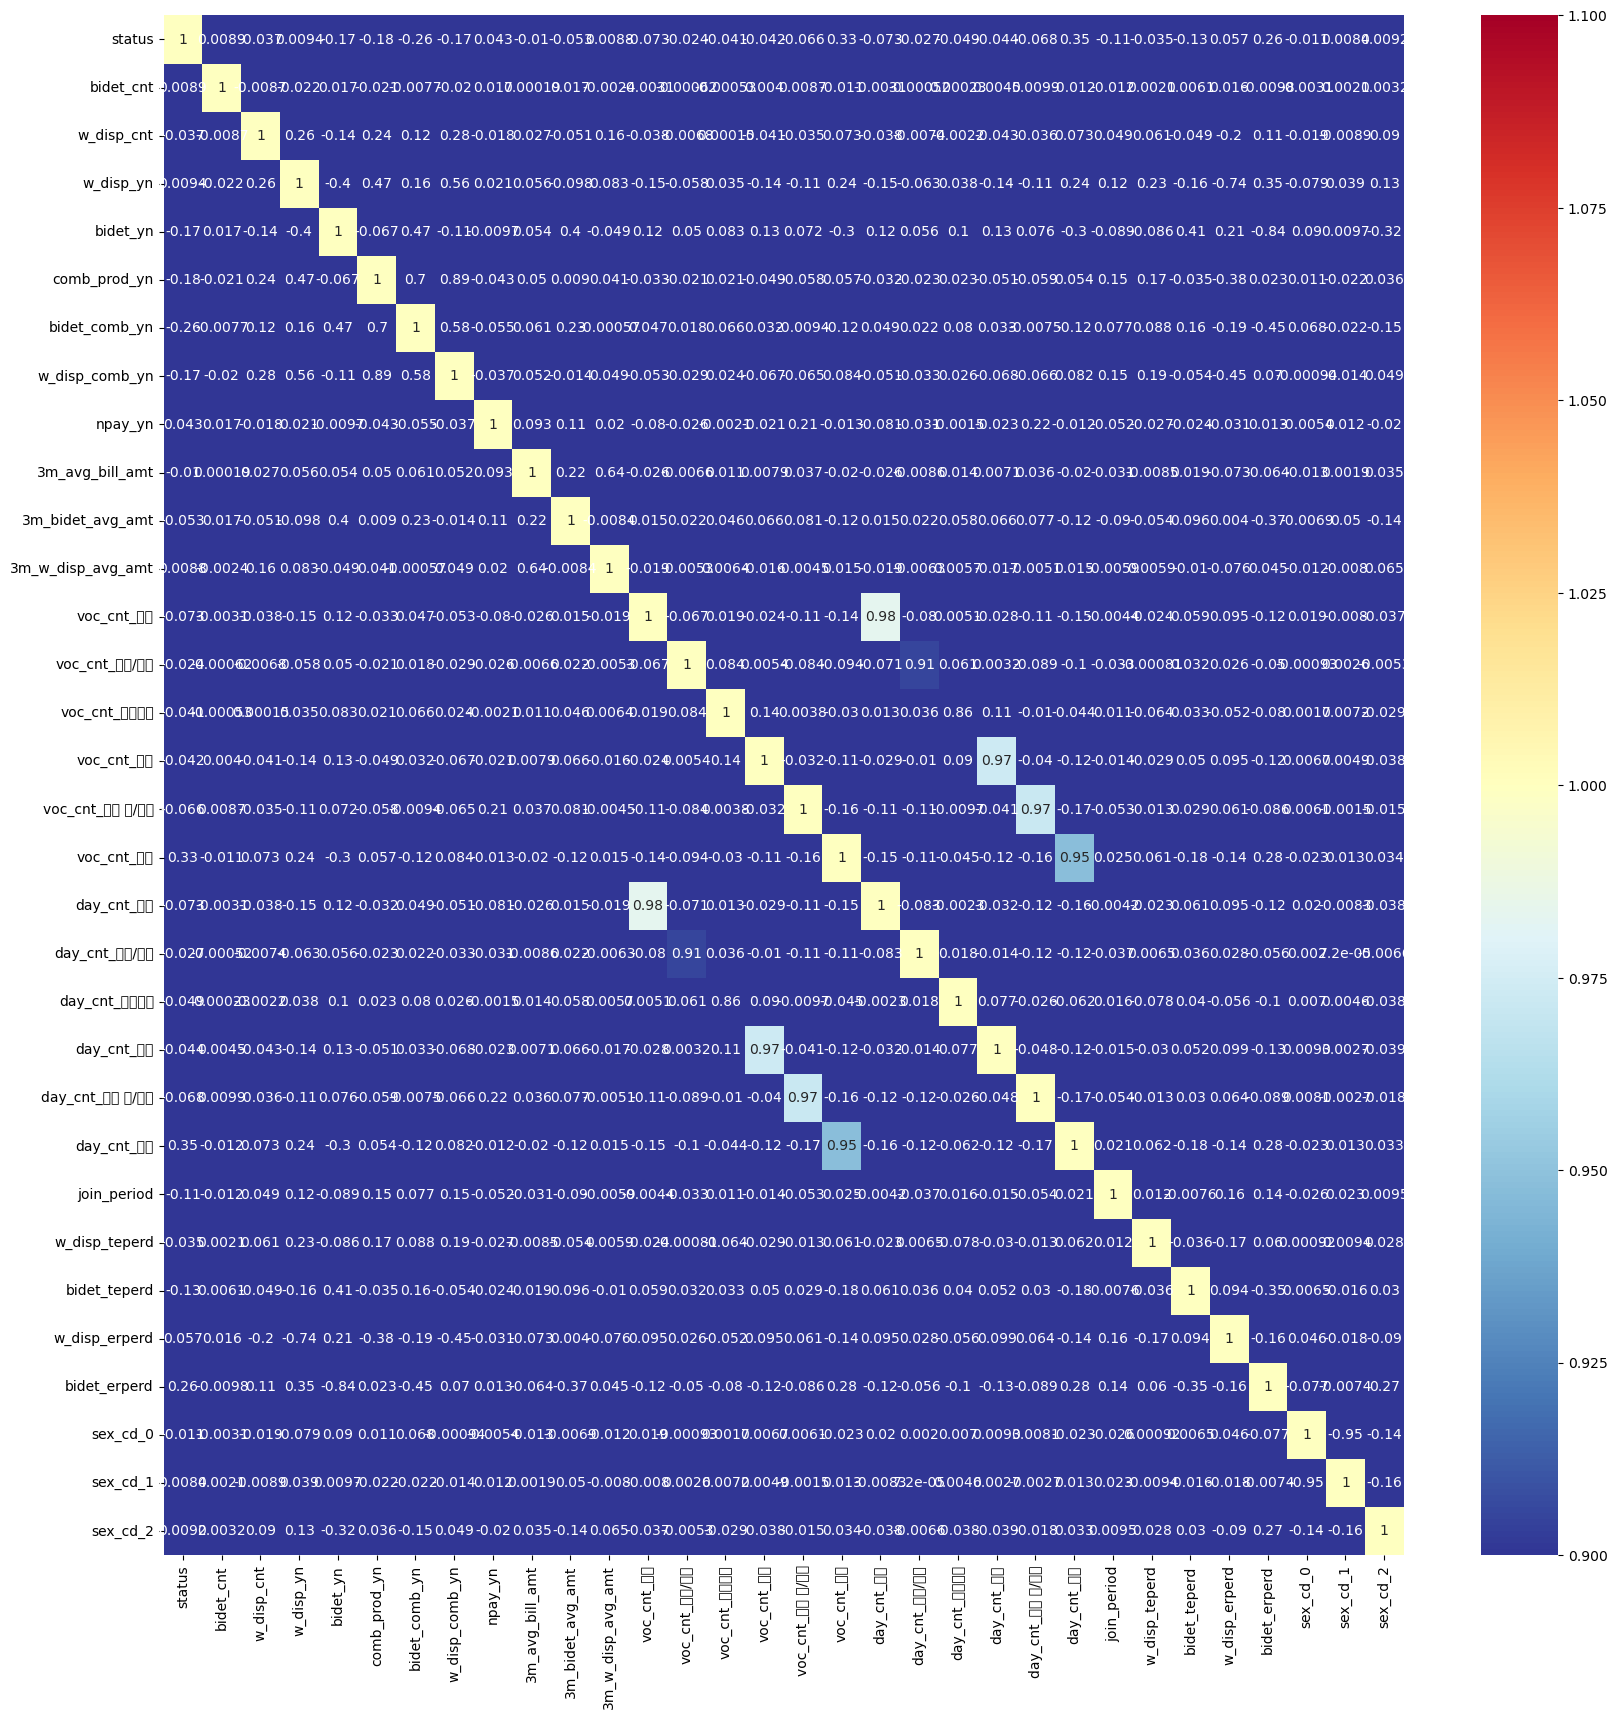

In [307]:
#변수 간 상관관계 시각화와 상관계수 0.9 이상 변수 확인
#그래프 크게 설정
plt.rcParams["figure.figsize"]=(20,20)
#train_data의 상관관계를 히트맵으로 그리기
sns.heatmap(train_data.corr(), annot=True, cmap='RdYlBu_r', vmin=1, vmax=1)
#그래프 크기 원래대로
plt.rcParams["figure.figsize"]=(5,5)

In [308]:
check=[]
mcol_linearity=[]

train_corr = train_data.corr() #모든 변수 상관관계 계산

#행, 열 간의 상관관계를 계산하므로 for문 두 번 중첩해서 돌리기
for idx in train_corr.index:
    #중복 계산에서 제외하기 위해 반복문을 수행할 때 체크리스트에 넣기
    check.append(idx)
    for column in train_corr.columns:
        #train_corr가 대각선 방향으로 대칭이므로 두 번 계산 피하기
        if column not in check:
            if (train_corr.loc[idx,column]>=0.9 and train_corr.loc[idx,column]<1) or (train_corr.loc[idx,column]<=-0.9 and train_corr.loc[idx,column]>-1):
                mcol_linearity.append([idx,column])
mcol_linearity 

[['voc_cnt_가입', 'day_cnt_가입'],
 ['voc_cnt_변경/조회', 'day_cnt_변경/조회'],
 ['voc_cnt_이용', 'day_cnt_이용'],
 ['voc_cnt_청구 수/미납', 'day_cnt_청구 수/미납'],
 ['voc_cnt_해지', 'day_cnt_해지'],
 ['sex_cd_0', 'sex_cd_1']]

In [309]:
#VIF 확인
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#VIF 계산 결과를 데이터프레임에 담기
vif = pd.DataFrame()
vif['VIF_Factor']=[variance_inflation_factor(train_data.values, i) for i in tqdm(range(train_data.shape[1]))]
vif['Feature'] = train_data.columns

#VIF 값 순서대로 내림차순 정렬하기
vif=vif.sort_values(by="VIF_Factor", ascending=False).reset_index().drop(columns='index')
vif

100%|██████████| 32/32 [00:03<00:00,  9.26it/s]


,VIF_Factor,Feature
0,80.575735,sex_cd_1
1,71.338545,sex_cd_0
2,30.152586,day_cnt_가입
3,29.990095,voc_cnt_가입
4,19.843187,voc_cnt_이용
5,19.705031,day_cnt_이용
6,17.886209,day_cnt_청구 수/미납
7,17.683989,voc_cnt_청구 수/미납
8,10.156465,day_cnt_해지
9,9.917503,voc_cnt_해지


In [310]:
#변수들 삭제
del_cols=['sex_cd_1', 'voc_cnt_가입', 'voc_cnt_이용', 'voc_cnt_청구 수/미납', 'voc_cnt_해지']

train_data=train_data.drop(del_cols, axis=1)
test_data=test_data.drop(del_cols, axis=1)
train_data.columns

Index(['status', 'bidet_cnt', 'w_disp_cnt', 'w_disp_yn', 'bidet_yn',
       'comb_prod_yn', 'bidet_comb_yn', 'w_disp_comb_yn', 'npay_yn',
       '3m_avg_bill_amt', '3m_bidet_avg_amt', '3m_w_disp_avg_amt',
       'voc_cnt_변경/조회', 'voc_cnt_업무협조', 'day_cnt_가입', 'day_cnt_변경/조회',
       'day_cnt_업무협조', 'day_cnt_이용', 'day_cnt_청구 수/미납', 'day_cnt_해지',
       'join_period', 'w_disp_teperd', 'bidet_teperd', 'w_disp_erperd',
       'bidet_erperd', 'sex_cd_0', 'sex_cd_2'],
      dtype='object')

In [311]:
# 전처리 완료.
#이제 머신러닝 & 딥러닝

In [312]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_data.drop('status',1), train_data['status'], random_state=10, stratify=train_data['status'])
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((41250, 26), (13750, 26), (41250,), (13750,))

In [313]:
#test data에서 status만 지우면 feature영역, status는 label 영역이 됨
x_test = test_data.drop('status', axis=1)
y_test = test_data['status']
x_test.shape, y_test.shape

((5000, 26), (5000,))

In [314]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

result = pd.DataFrame([], columns=['acc', 'recall', 'precision', 'F1-score'])

#파라미터
#model_name : 모델 이름(str)
#pred : 예측 결과

#actual : 실제값(y_test)
def result_view(model_name, pred, actual):
    #정확도
    acc = round(accuracy_score(actual, pred),3)
    #정밀도
    precision = round(precision_score(actual, pred), 3)
    #재현율
    recall = round(recall_score(actual, pred), 3)
    #F1 Score
    F1 = round(f1_score(actual, pred), 3)

    result.loc[model_name]=(acc, recall, precision, F1)
    result.sort_values(by='acc', inplace=True, ascending=False)

    print(result)

    plt.figure(figsize=(8,5))
    for idx in result.index:
        x_values = result.columns #x축 지점의 값들
        y_values = result.loc[idx] #y축 지점의 값들
        plt.plot(x_values, y_values) #선 그래프 그리기
        plt.annotate(text=round(result.loc[idx, 'acc'],3), xy=(0, result.loc[idx, 'acc']), xytext=(0, result.loc[idx, 'acc']), ha='center', fontsize=14)
        plt.annotate(text=round(result.loc[idx, 'acc'],3), xy=(1, result.loc[idx, 'acc']), xytext=(1, result.loc[idx, 'acc']), ha='center', fontsize=14)
        plt.annotate(text=round(result.loc[idx, 'acc'],3), xy=(2, result.loc[idx, 'acc']), xytext=(2, result.loc[idx, 'acc']), ha='center', fontsize=14)

    plt.legend(result.index, loc=4)

    plt.show()


In [315]:
from sklearn.linear_model import LogisticRegression

findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not 

                       acc  recall  precision  F1-score
Logistic Regression  0.734   0.584       0.72     0.645


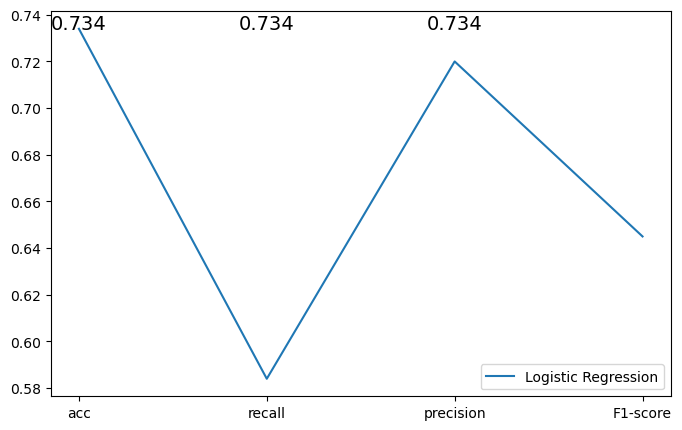

In [316]:
model_lr = LogisticRegression(random_state=21)
model_lr.fit(x_train,y_train)
pred_lr=model_lr.predict(x_test)
result_view('Logistic Regression', pred_lr, y_test)

In [317]:
from sklearn.neighbors import KNeighborsClassifier
model_knn=KNeighborsClassifier()
model_knn.fit(x_train, y_train)

KNeighborsClassifier()

In [318]:
pred_knn = model_knn.predict(x_test)
result_view('KNN', pred_knn, y_test)

AttributeError: 'Flags' object has no attribute 'c_contiguous'

findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not 

                          acc  recall  precision  F1-score
Logistic Regression     0.734   0.584       0.72     0.645
support vector machine  0.734   0.603       0.71     0.652


findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not 

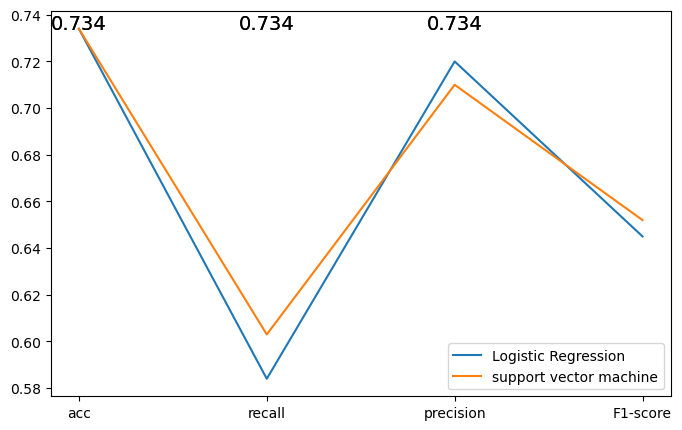

In [319]:
from sklearn.svm import SVC
model_svm = SVC(random_state=21)
model_svm.fit(x_train, y_train)
pred_svm=model_svm.predict(x_test)
result_view('support vector machine', pred_svm, y_test)

In [320]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1, max_features=None, max_depth=5, max_leaf_nodes=None, random_state=21)

findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not 

                          acc  recall  precision  F1-score
Decision Tree           0.746   0.624      0.724     0.670
Logistic Regression     0.734   0.584      0.720     0.645
support vector machine  0.734   0.603      0.710     0.652


findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not 

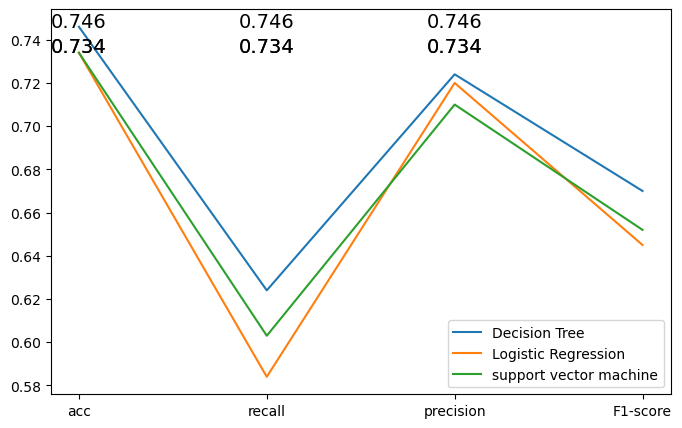

In [321]:
model_dt.fit(x_train, y_train)
pred_dt = model_dt.predict(x_test)
result_view('Decision Tree', pred_dt, y_test)

In [330]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_jobs=-1, n_estimators=100,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  max_features='50',
                                  max_depth=None,
                                  max_leaf_nodes=None,
                                  random_state=21)

In [331]:
model_rf.fit(x_train,y_train)

InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got '50' instead.

In [332]:
pred_rf=model_rf_predict(x_test)
result_view('Random Forest', pred_rf, y_test)

NameError: name 'model_rf_predict' is not defined